# IWT Project Visualizations & Analysis

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False

import os
from pathlib import Path

cwd = Path(os.getcwd())
if cwd.name == "notebooks":
    os.chdir("..")

In [ ]:
# Import Libraries
from functools import cmp_to_key
from collections import Counter
from collections import defaultdict
import cartopy.crs as ccrs  
import geopandas as gpd
from cartopy.feature import BORDERS, COASTLINE
from shapely.geometry import LineString
from adjustText import adjust_text
import pylev
import tqdm.auto as tqdm
import csv
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import scipy.stats as stats
import pandas as pd
import networkx as nx
import numpy as np
import torch
import matplotlib.colors as mcolors
import tqdm.auto as tqdm
import torch_geometric as tg
from torch.utils.data import DataLoader
from fuzzywuzzy import process
from methods.data_handling import base_flight_network
from methods import seizure_data, network_data, nx_utils
from methods.filepath_utils import DataPathing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

### Load Networks

#### Full Flight Network

In [3]:
# Read in Network File
import pickle
file_path = os.path.join('./data_cache/seizure_augmented_network.gpickle')
with open(os.path.join(os.getcwd(), file_path), 'rb') as f:
    full = pickle.load(f)

In [4]:
# Calculate Degree, Betweeness, Closeness, and Eigenvector Centrality for the full network
degree_full = nx.degree_centrality(full)
between_full = nx.betweenness_centrality(full)
close_full = nx.closeness_centrality(full)
eigen_full = nx.eigenvector_centrality(full)
pr_full = nx.pagerank(full)
degree_in_full = nx.in_degree_centrality(full)
degree_out_full = nx.out_degree_centrality(full)

# Add the calculated centrality measures to the nodes
nx.set_node_attributes(full, degree_full, 'degree_full')
nx.set_node_attributes(full, between_full, 'between_full')
nx.set_node_attributes(full, close_full, 'close_full')
nx.set_node_attributes(full, eigen_full, 'eigen_full')
nx.set_node_attributes(full, pr_full, 'pr_full')
nx.set_node_attributes(full, degree_in_full, 'degree_in_full')
nx.set_node_attributes(full, degree_out_full, 'degree_out_full')

#### Observed Trafficking Network

In [6]:
# Read in Paths
file_path = os.path.join('./data_cache/routes_paths.pkl')
with open(os.path.join(os.getcwd(), file_path), 'rb') as f:
    routes = pickle.load(f)

# Remove entries that don't have at least two nodes
routes = [tuple(sublist) for sublist in routes if len(sublist) > 1]
routes

# Create a dictionary for each node in routes whose value is the number of times it appears in routes
incident_counts = Counter([node for path in routes for node in path])

# Separate each entry into distinct edges between nodes
routes2 = []
for tup in routes:
    if len(tup) == 2:                       # If there are only two parts to the path, append it directly as an edge
        routes2.append(tup)
    else:
        for i in range(len(tup)-1):         # If there are multiple parts to the path, append each distinct edge connecting them
            routes2.append((tup[i], tup[i + 1]))

In [7]:
# Create networkx graph of the seizure routes
seizure = nx.DiGraph()

# Add nodes and edges to the graph
seizure.add_edges_from(routes2)

# Add features to each node that match the full flight network
seizure_nodes = list(seizure.nodes())

# Retrieve the features attached to the nodes in the full network and add them to the seizure network nodes
seizure_nodes_data = {node: full.nodes[node] for node in seizure_nodes}
for node, data in seizure_nodes_data.items():
    seizure.nodes[node].update(data)

# Add incident counts as feature for nodes in seizure network
for node in seizure.nodes():
    seizure.nodes[node]['incident_counts'] = incident_counts[node]

# Add normalized incident counts as feature for nodes in seizure network
max_incidents = max(incident_counts.values())
for node in seizure.nodes():
    seizure.nodes[node]['incident_counts_norm'] = incident_counts[node] / max_incidents

# Count the number of trafficking incidents that occur at each edge and store in a dictionary -- used for visualization edge weigh
edge_counts = Counter(routes2)

# Add edge_counts as edge attribute to the seizure network
nx.set_edge_attributes(seizure, edge_counts, 'edge_count')

# Normalize the edge_count to between 0 and 1
edge_counts_norm = {}
max_edge_count = max(edge_counts.values())
for edge, count in edge_counts.items():
    edge_counts_norm[edge] = count / max_edge_count

# # Add the edge_counts as an attribute to the edges in the seizure network
# nx.set_edge_attributes(seizure, edge_counts_norm, 'edge_count_norm')

# Calculate the degree, betweenness, closeness, and eigenvector centrality for the seizure network
degree_seizure = nx.degree_centrality(seizure)
between_seizure = nx.betweenness_centrality(seizure)
close_seizure = nx.closeness_centrality(seizure)
eigen_seizure = nx.eigenvector_centrality(seizure)
pr_seizure = nx.pagerank(seizure)
degree_in_seizure = nx.in_degree_centrality(seizure)
degree_out_seizure = nx.out_degree_centrality(seizure)

# Add the calculated centrality measures to the nodes
nx.set_node_attributes(seizure, degree_seizure, 'degree_seizure')
nx.set_node_attributes(seizure, between_seizure, 'between_seizure')
nx.set_node_attributes(seizure, close_seizure, 'close_seizure')
nx.set_node_attributes(seizure, eigen_seizure, 'eigen_seizure')
nx.set_node_attributes(seizure, pr_seizure, 'pr_seizure')
nx.set_node_attributes(seizure, degree_in_seizure, 'degree_in_seizure')
nx.set_node_attributes(seizure, degree_out_seizure, 'degree_out_seizure')

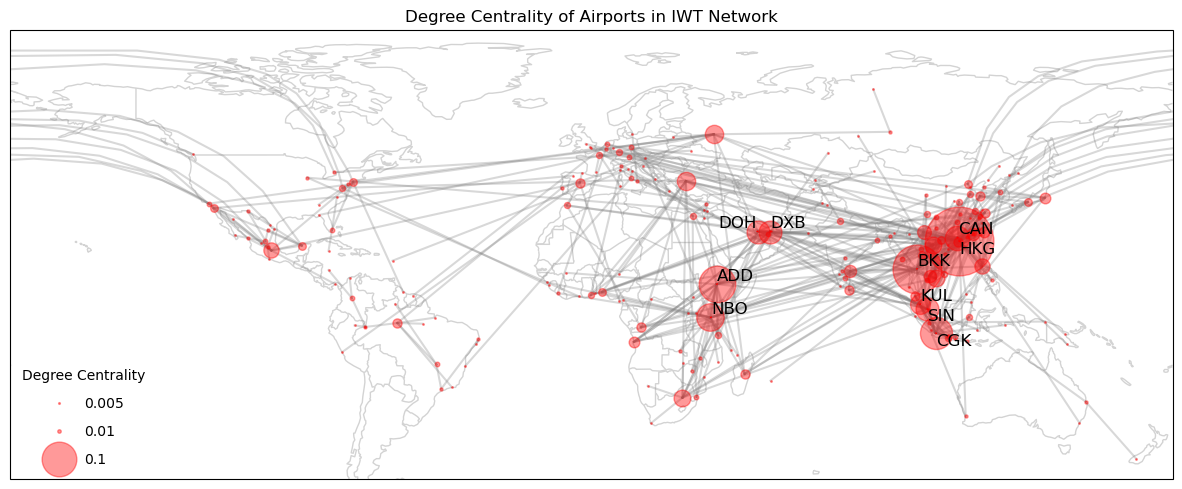

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='#d3d3d3')
ax.add_feature(COASTLINE, edgecolor='#d3d3d3')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Plot edges
for edge in seizure.edges():
    start_node = seizure.nodes[edge[0]]
    end_node = seizure.nodes[edge[1]]
    start_lon, start_lat = start_node['longitude'], start_node['latitude']
    end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
    if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
        plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.3)
    else:
        ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.3)

for node in seizure.nodes:  
    lon, lat = seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude']
    size = seizure.nodes[node]['degree_seizure'] * 250
    ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4) 

top_nodes = sorted(seizure.nodes(), key=lambda x: seizure.nodes[x]['degree_seizure'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

sizes = [0.005, 0.01 , 0.1]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size*250, alpha=0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Degree Centrality")

ax.set_title("Degree Centrality of Airports in IWT Network")
plt.show()


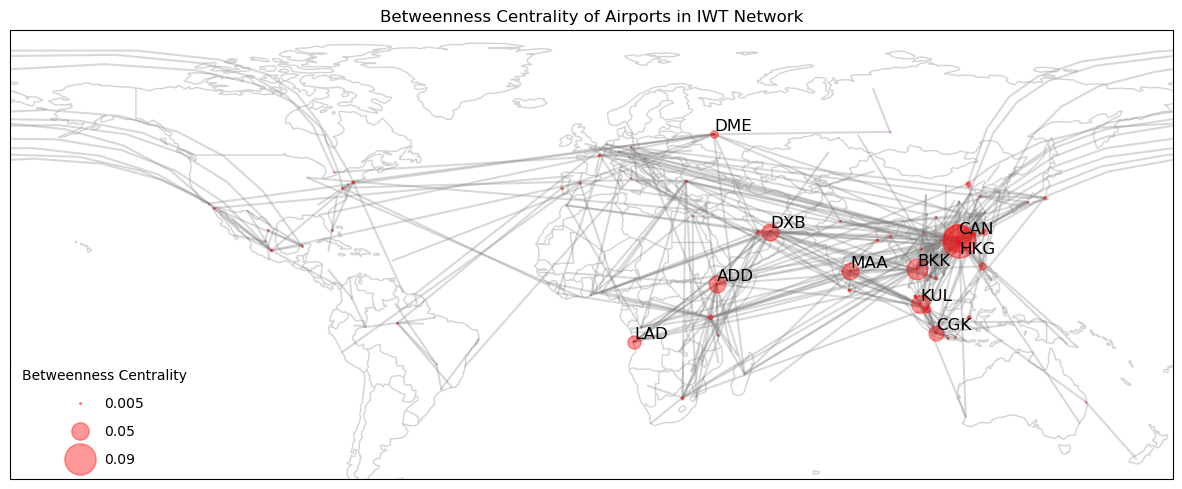

In [ ]:
# Visualize this Network -- Size of Node = Degree Centrality in Seizure Network
scaling_factor = 100
fig, ax = plt.subplots(figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='#d3d3d3')
ax.add_feature(COASTLINE, edgecolor='#d3d3d3')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Plot edges
for edge in seizure.edges():
    start_node = seizure.nodes[edge[0]]
    end_node = seizure.nodes[edge[1]]
    start_lon, start_lat = start_node['longitude'], start_node['latitude']
    end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
    # Check if the flight is between Asia and North America
    if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
        plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.3)
    else:
        ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.3)

# Plot and label the top five nodes with a different color
for node in seizure.nodes:  
    lon, lat = seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude']
    size = seizure.nodes[node]['between_seizure'] * 250
    ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)  # Red color for top nodes, adjust alpha as needed

# Label the top 10 nodes on the map based on their degree centrality
top_nodes = sorted(seizure.nodes(), key=lambda x: seizure.nodes[x]['between_seizure'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "Degree Centrality"
sizes = [0.005, 0.05 , 0.09]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size*250, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Betweenness Centrality")

# Set title
ax.set_title("Betweenness Centrality of Airports in IWT Network")

# Show map
plt.show()


### Network Comparison: Observed IWT Paths vs. Full Flight Network

In [33]:
# Transform Networkx Attributes into Dataframe for Analysis
seizure_data = {node: data for node, data in seizure.nodes(data=True)}
seizure_df = pd.DataFrame.from_dict(seizure_data, orient='index').reset_index()
seizure_df = seizure_df.rename(columns={'index': 'ID'})

full_data2 = {node: data for node, data in full.nodes(data=True)}
full_df2 = pd.DataFrame.from_dict(full_data2, orient='index').reset_index()
full_df2 = full_df2.rename(columns={'index': 'ID'})

# Merge the data on 'ID' and combine the DataFrames
merged_data =pd.merge(seizure_df, full_df2, on=seizure_df.columns.intersection(full_df2.columns).tolist(), how='outer')

# If the values for degree_seizure is NaN, please maked a new column 'in_seizure?' equal to 0 and 1 otherwise
merged_data['in_seizure?'] = np.where(merged_data['degree_seizure'].isnull(), 0, 1)

# Save to a CSV file
merged_data.to_csv('merged_data.csv')

In [34]:
merged_data

ID    id                                 name  \
0     BNE  3320       Brisbane International Airport   
1     ZQN  2030     Queenstown International Airport   
2     IMF  3050                       Imphal Airport   
3     DEL  3093  Indira Gandhi International Airport   
4     KBP  2939       Boryspil International Airport   
...   ...   ...                                  ...   
1928  PKE  6317                       Parkes Airport   
1929  GFF  6271                     Griffith Airport   
1930  MIM  6294                    Merimbula Airport   
1931  MYA  6302                       Moruya Airport   
1932  OAG  6793                       Orange Airport   

                          city      country  ICAO   latitude   longitude  \
0                     Brisbane    australia  YBBN -27.384199  153.117004   
1     Queenstown International  new zealand  NZQN -45.021099  168.738998   
2                       Imphal        india  VEIM  24.760000   93.896698   
3                        Delhi        india  VIDP  28.566500   77.103104   
4                         Kiev      ukraine  UKBB  50.345001   30.894699   
...                        ...          ...   ...        ...         ...   
1928                    Parkes    australia  YPKS -33.131401  148.238998   
1929                  Griffith    australia  YGTH -34.250801  146.067001   
1930                 Merimbula    australia  YMER -36.908600  149.901001   
1931                    Moruya    australia  YMRY -35.897800  150.143997   
1932                    Orange    australia  YORG -33.381699  149.132996   

      altitude  timezone  ... incident_counts incident_counts_norm  \
0           13      10.0  ...             2.0             0.023810   
1         1171      12.0  ...             1.0             0.011905   
2         2540       5.5  ...             2.0             0.023810   
3          777       5.5  ...             5.0             0.059524   
4          427       2.0  ...             2.0             0.023810   
...        ...       ...  ...             ...                  ...   
1928      1069      10.0  ...             NaN                  NaN   
1929       439      10.0  ...             NaN                  NaN   
1930         7      10.0  ...             NaN                  NaN   
1931        14      10.0  ...             NaN                  NaN   
1932      3115      10.0  ...             NaN                  NaN   

     degree_seizure between_seizure  close_seizure  eigen_seizure  pr_seizure  \
0          0.008811        0.002398       0.093213   6.189501e-03    0.002374   
1          0.004405        0.000000       0.080734   2.000122e-03    0.003614   
2          0.004405        0.000000       0.000000   2.549365e-16    0.001596   
3          0.017621        0.004210       0.084495   3.213811e-03    0.003402   
4          0.004405        0.000000       0.000000   2.549365e-16    0.001596   
...             ...             ...            ...            ...         ...   
1928            NaN             NaN            NaN            NaN         NaN   
1929            NaN             NaN            NaN            NaN         NaN   
1930            NaN             NaN            NaN            NaN         NaN   
1931            NaN             NaN            NaN            NaN         NaN   
1932            NaN             NaN            NaN            NaN         NaN   

      degree_in_seizure  degree_out_seizure  in_seizure?  
0              0.004405            0.004405            1  
1              0.004405            0.000000            1  
2              0.000000            0.004405            1  
3              0.008811            0.008811            1  
4              0.000000            0.004405            1  
...                 ...                 ...          ...  
1928                NaN                 NaN            0  
1929                NaN                 NaN            0  
1930                NaN                 NaN            0  
1931             

##### OLD PLOTS

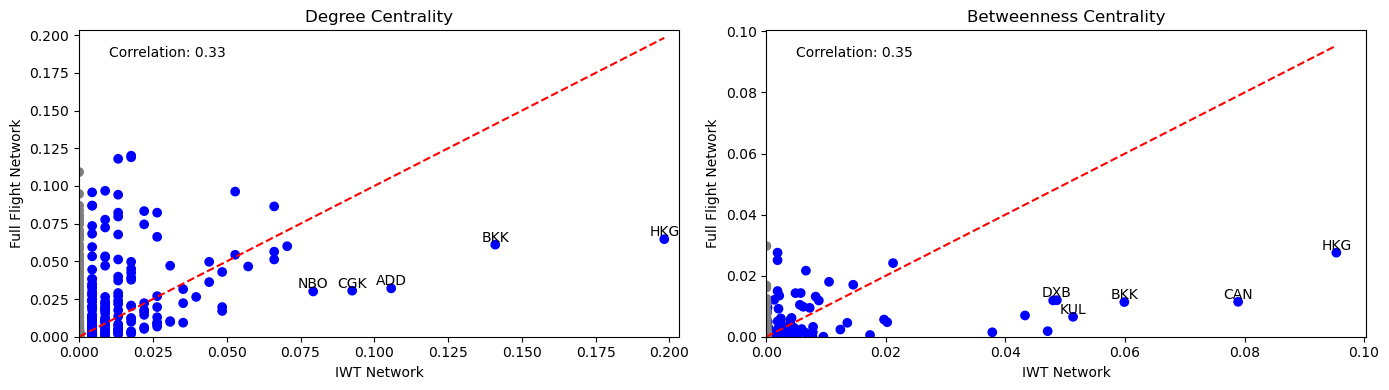

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Centrality metrics columns for full flight and subset networks
centrality_metrics = ['degree', 'between']

# Replace NaN values in subset network columns with 0
subset_columns = [f'{metric}_seizure' for metric in centrality_metrics]
merged_data[subset_columns] = merged_data[subset_columns].fillna(0)

# Initialize Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # Adjusted figsize to be wider and maintain square shape

# Plot Data
for i, metric in enumerate(centrality_metrics):

    # Nodes both in the seizure and full network
    non_zero_indices = (merged_data[f'{metric}_seizure'] != 0) & (merged_data[f'{metric}_full'] != 0)

    ax = axes[i]

    # Set X and Y Scale for each Metric
    ax.set_xlim(0, max(merged_data[f'{metric}_full'].max()+0.005, merged_data[f'{metric}_seizure'].max()+0.005))
    ax.set_ylim(0, max(merged_data[f'{metric}_full'].max()+0.005, merged_data[f'{metric}_seizure'].max()+0.005))
    
    # Add a diagonal red line representing the x = y point
    ax.plot([0, max(merged_data[f'{metric}_full'].max(), merged_data[f'{metric}_seizure'].max())], [0, max(merged_data[f'{metric}_full'].max(), merged_data[f'{metric}_seizure'].max())], 'r--')

    # Color nodes with a 0 value in the seizure column grey, otherwise blue
    ax.scatter(merged_data[f'{metric}_seizure'], merged_data[f'{metric}_full'], c=np.where(merged_data[f'{metric}_seizure'] == 0, 'grey', 'blue'))

    # Label Plot
    if metric == 'degree':
        ax.set_title(f'{metric.split("_")[0].capitalize()} Centrality')
    else:
        ax.set_title('Betweenness Centrality')

    ax.set_xlabel('IWT Network')
    ax.set_ylabel('Full Flight Network')
    
    # Label the ID of the nodes that have the top 5 highest values in the seizure network
    top_seizure = merged_data.nlargest(5, f'{metric}_seizure')
    for index, row in top_seizure.iterrows():
        ax.text(row[f'{metric}_seizure'], row[f'{metric}_full'], row['ID'], fontsize=10, ha='center', va='bottom')

    correlation = pearsonr(merged_data[f'{metric}_seizure'][non_zero_indices], merged_data[f'{metric}_full'][non_zero_indices])
    ax.text(0.05, 0.95, f'Correlation: {correlation[0]:.2f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

plt.tight_layout()
plt.show()


/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/2100829446.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=bins))['in_seizure?'].mean() * 100
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/2100829446.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=bins))['in_seizure?'].mean() * 100


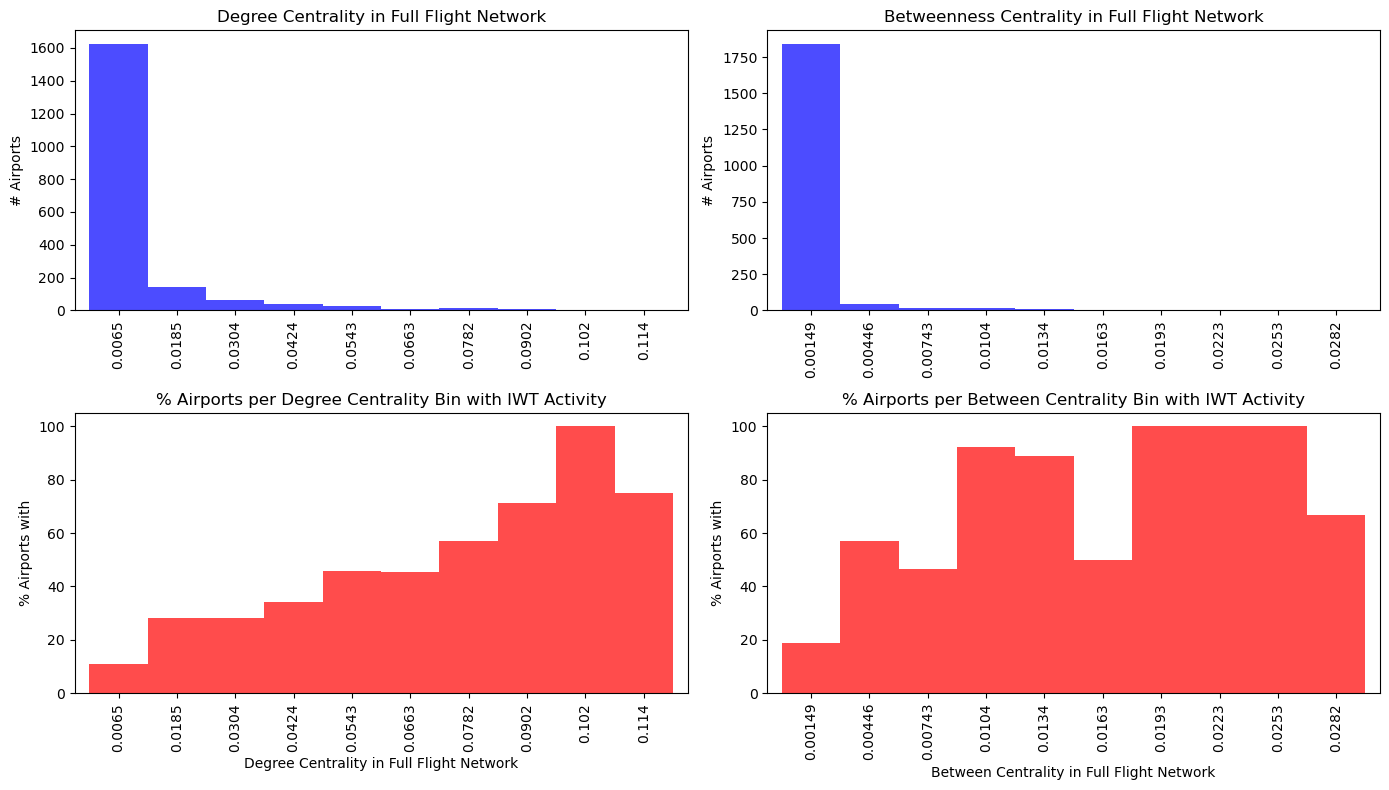

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the centrality measures
centrality_measures = ['degree_full', 'between_full']

# Define the number of bins
num_bins = 10

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))  # Adjusted figsize to 14x5

# Iterate over each centrality measure
for i, centrality_measure in enumerate(centrality_measures):
    # Convert the centrality measure column to numeric if needed
    merged_data[centrality_measure] = pd.to_numeric(merged_data[centrality_measure], errors='coerce')
    
    # Calculate histogram for the number of airports in each bin
    bin_counts, bins = np.histogram(merged_data[centrality_measure], bins=num_bins)
    bin_labels = [f"{(bins[i] + bins[i+1]) / 2:.3g}" for i in range(len(bins) - 1)]
    bin_counts = pd.Series(bin_counts, index=bin_labels)
    bin_counts.plot(kind='bar', ax=axes[0,i], color='blue', alpha=0.7, label='# Airports', width=1)
    axes[0,i].set_ylabel('# Airports')
    axes[0,i].set_title(centrality_measure.split('_')[0].capitalize() + ' Centrality in Full Flight Network')

    # Calculate the percentage of airports in each bin that are in the seizure network
    bin_percentages = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=bins))['in_seizure?'].mean() * 100
    
    # Plot the percentage for each bin that are in seizure
    bin_percentages.plot(kind='bar', ax=axes[1,i], color='red', alpha=0.7, label='% Airports in Seizure Network', width=1)
    axes[1,i].set_title('% Airports per ' + centrality_measure.split('_')[0].capitalize() + ' Centrality Bin with IWT Activity')
    axes[1,i].set_xlabel(centrality_measure.split('_')[0].capitalize() + ' Centrality in Full Flight Network')
    axes[1,i].set_ylabel('% Airports with')

    # Set the x-axis tick labels
    axes[0, i].set_xticklabels(bin_labels)
    axes[1, i].set_xticklabels(bin_labels)

# Adjust layout
plt.tight_layout()

# Update title for 'between' centrality
axes[0, 1].set_title('Betweenness Centrality in Full Flight Network')

plt.show()


##### NEW PLOTS

In [46]:
###### FIGURE 3A

# Centrality metrics columns for full flight and subset networks
centrality_metrics = ['degree', 'between']

# Replace NaN values in subset network columns with 0
subset_columns = [f'{metric}_seizure' for metric in centrality_metrics]
merged_data[subset_columns] = merged_data[subset_columns].fillna(0)

# Initialize Bokeh plots
plots = []
for metric in centrality_metrics:
    # Create a new plot for each metric
    if metric == 'between':
        title = 'Betweenness Centrality in IWT vs. Full Flight Network per Airport'
    else:
        title = 'Degree Centrality in IWT vs. Full Flight Network per Airport'
    p = figure(title=title, x_axis_label='IWT Network', y_axis_label='Full Flight Network',
               width=600, height=350, x_range=(-0.001, merged_data[f'{metric}_seizure'].max() * 1.2),
               y_range=(-0.001, merged_data[f'{metric}_full'].max() * 1.2))

    # Remove grid lines
    p.grid.visible = False

    # Scatter plot with correct color mapping
    source = ColumnDataSource(data=dict(
        x=merged_data[f'{metric}_seizure'],
        y=merged_data[f'{metric}_full'],
        color=np.where(merged_data[f'{metric}_seizure'] == 0, 'grey', 'red'),  # Map colors based on IWT Network
        ID=merged_data['ID']
    ))

    p.scatter('x', 'y', source=source, fill_alpha=0.6, line_color=None, size=8, fill_color='color')

    # Add diagonal red line
    p.line([0, merged_data[f'{metric}_full'].max()*1.2], [0, merged_data[f'{metric}_full'].max()*1.2], line_color='blue', line_dash='dashed')

    # Label the top 5 highest values in the seizure network
    top_seizure = merged_data.nlargest(5, f'{metric}_seizure')
    for _, row in top_seizure.iterrows():
        differential = 0.004 if metric == 'degree' else 0.002
        p.add_layout(Arrow(end=NormalHead(size=3, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
        p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # Label the top 2 in the full flight network
    top_full = merged_data.nlargest(2, f'{metric}_full')
    for _, row in top_full.iterrows():
        if metric == 'degree' and row['ID'] == 'FRA':
            p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full']-.1*differential,
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full']+ .5*differential))
            p.add_layout(Label(x=row[f'{metric}_seizure'] + 1.1*differential, y=row[f'{metric}_full'], text=row['ID'], text_font_size='10px'))

        else: 
            differential = 0.004 if metric == 'degree' else 0.002
            p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                            x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                            x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
            p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # Label the top 2 in the full flight network and NOT in IWT
    top_full_non_iwt = merged_data[(merged_data[f'{metric}_seizure'] == 0) & (merged_data[f'{metric}_full'] != 0)].nlargest(2, f'{metric}_full')
    for _, row in top_full_non_iwt.iterrows():
        p.add_layout(Arrow(end=NormalHead(size=5, line_width=0.05, line_color='grey'),
                           x_start=row[f'{metric}_seizure'], y_start=row[f'{metric}_full'],
                           x_end=row[f'{metric}_seizure'] + differential, y_end=row[f'{metric}_full'] + differential))
        p.add_layout(Label(x=row[f'{metric}_seizure'] + differential, y=row[f'{metric}_full'] + differential, text=row['ID'], text_font_size='10px'))

    # # Add correlation information
    corr_value = merged_data[[f'{metric}_seizure', f'{metric}_full']].corr().iloc[0, 1]
    # x_coord = 0.05 * (p.x_range.end - p.x_range.start)
    # y_coord = 0.05 * (p.y_range.end - p.y_range.start)
    # p.add_layout(Label(x=x_coord, y=y_coord, x_units='screen', y_units='screen',
                    #    text=f'Correlation: {corr_value:.2f}', text_font_size='10px', text_color='black'))

    plots.append(p)


# Arrange plots in a grid layout with shared x-axis and spacing
grid = gridplot([[plots[0], plots[1]]], toolbar_location=None)

# Show the grid
show(grid)

In [50]:
#### FIGURE 3B
# from plotting import figure, show
from bokeh.layouts import gridplot
import numpy as np
import pandas as pd

# Define the centrality measures
centrality_measures = ['degree_full', 'between_full']

# Define the number of bins
num_bins = 10

# Specific bin centers for each centrality measure
bin_centers_degree = np.array([0.00649586, 0.01845238, 0.0304089, 0.04236542, 0.05432195,
                               0.06627847, 0.07823499, 0.09019151, 0.10214803, 0.11410455])

bin_centers_between = np.array([0.00148543, 0.00445629, 0.00742715, 0.010398, 0.01336886,
                                0.01633972, 0.01931058, 0.02228144, 0.02525229, 0.02822315])

# Create data for histograms
hist_data = {}

# Calculate histograms for each centrality measure
for centrality_measure in centrality_measures:
    # Convert the centrality measure column to numeric if needed
    merged_data[centrality_measure] = pd.to_numeric(merged_data[centrality_measure], errors='coerce')
    
    # Calculate histogram
    hist_data[centrality_measure], _ = np.histogram(merged_data[centrality_measure], bins=num_bins)

# Create figure for Degree Centrality
p_degree = figure(title='# Airports in Full Flight Network per Degree Centrality Bin', x_axis_label='Degree Centrality in Full Flight Network', y_axis_label='# Airports', width=600, height=350, y_range=(0, max(hist_data['degree_full']) * 1.1))
p_degree.vbar(x=bin_centers_degree, top=hist_data['degree_full'], width=0.012, color='blue', alpha=0.7)

# Add raw counts to the top of each bar
for x, counts in zip(bin_centers_degree, hist_data['degree_full']):
    p_degree.text(x=x, y=counts + 10, text=[str(counts)], text_align='center', text_font_size='8pt')

# Set x-axis properties for Degree Centrality plot
p_degree.xaxis.ticker = bin_centers_degree
p_degree.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

# Create figure for Betweenness Centrality
p_between = figure(title='# Airports in Full Flight Network per Betweenness Centrality Bin', x_axis_label='Betweenness Centrality in Full Flight Network', y_axis_label='# Airports', width=600, height=350, y_range=(0, max(hist_data['between_full']) * 1.1))
p_between.vbar(x=bin_centers_between, top=hist_data['between_full'], width=0.003, color='green', alpha=0.7)

# Add raw counts to the top of each bar
for x, counts in zip(bin_centers_between, hist_data['between_full']):
    p_between.text(x=x, y=counts + 10, text=[str(counts)], text_align='center', text_font_size='8pt')

# Set x-axis properties for Betweenness Centrality plot
p_between.xaxis.ticker = bin_centers_between
p_between.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

# Remove the grid
p_degree.grid.visible = False
p_between.grid.visible = False

# Arrange plots side-by-side in a grid layout
grid = gridplot([[p_degree, p_between]], toolbar_location=None)

# Show the grid
show(grid)


In [48]:
### FIGURE 3C

# Define the centrality measures
centrality_measures = ['degree_full', 'between_full']

# Define the number of bins
num_bins = 10

# Specific bin centers for each centrality measure
bin_centers_degree = np.array([0.00649586, 0.01845238, 0.0304089, 0.04236542, 0.05432195,
                               0.06627847, 0.07823499, 0.09019151, 0.10214803, 0.11410455])

bin_centers_between = np.array([0.00148543, 0.00445629, 0.00742715, 0.010398, 0.01336886,
                                0.01633972, 0.01931058, 0.02228144, 0.02525229, 0.02822315])

# Calculate percentages of airports in IWT network for each centrality measure and bin
bin_percentages = {}

for centrality_measure in centrality_measures:
    # Cut data into bins and calculate mean of 'in_IWT' column for each bin
    bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100

# Create figure for Degree Centrality
p_degree = figure(title='% of Airports in IWT per Degree Centrality Bin', x_axis_label='Degree Centrality in Full Flight Network', y_axis_label='% of Airports in IWT', width=600, height=350, y_range=(0, 110))
p_degree.vbar(x=bin_centers_degree, top=bin_percentages['degree_full'], width=0.012, color='blue', alpha=0.7)

# Add percentages to the top of each bar
for x, percent in zip(bin_centers_degree, bin_percentages['degree_full']):
    p_degree.text(x=x, y=percent + 1, text=[f'{percent:.0f}%'], text_align='center', text_font_size='8pt')

# Set x-axis properties for Degree Centrality plot
p_degree.xaxis.ticker = bin_centers_degree
p_degree.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

# Create figure for Betweenness Centrality
p_between = figure(title='% of Airports in IWT per Betweenness Centrality Bin', x_axis_label='Betweenness Centrality in Full Flight Network', y_axis_label='% of Airports in IWT', width=600, height=350, y_range=(0, 110))
p_between.vbar(x=bin_centers_between, top=bin_percentages['between_full'], width=0.003, color='green', alpha=0.7)

# Add percentages to the top of each bar
for x, percent in zip(bin_centers_between, bin_percentages['between_full']):
    p_between.text(x=x, y=percent + 1, text=[f'{percent:.0f}%'], text_align='center', text_font_size='8pt')

# Set x-axis properties for Betweenness Centrality plot
p_between.xaxis.ticker = bin_centers_between
p_between.xaxis.major_label_orientation = np.pi / 4  # Rotate labels for better readability

# Remove the grid
p_degree.grid.visible = False
p_between.grid.visible = False

# Arrange plots side-by-side in a grid layout
grid = gridplot([[p_degree, p_between]], toolbar_location=None)

# Show the grid
show(grid)


/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/3285891862.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_2196/3285891862.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_percentages[centrality_measure] = merged_data.groupby(pd.cut(merged_data[centrality_measure], bins=num_bins))[['in_seizure?']].mean().squeeze() * 100


### Airport-Level Observations (Non-Path) Analysis

#### Organize Data

In [16]:
# Read in Updated ROUTES Data
compiled_routes = pd.read_excel('/Users/hannahmurray/Documents/GitHub/IWTTraffickerPathPrediction/IWT_data/ROUTES DATA/Compiled_ROUTES_Data.xlsx', header=1)
compiled_routes

Unnamed: 0 Database1 Database2 Database3 Database4    Year     Month  \
0             1     Ivory       NaN       NaN       NaN  2019.0     April   
1             2  Reptiles       NaN       NaN       NaN  2019.0  December   
2             3  Reptiles       NaN       NaN       NaN  2019.0       NaN   
3             4   Mammals       NaN       NaN       NaN  2020.0  February   
4             5   Mammals       NaN       NaN       NaN  2020.0       May   
..          ...       ...       ...       ...       ...     ...       ...   
970         971       NaN       NaN       NaN       NaN     NaN       NaN   
971         972       NaN       NaN       NaN       NaN     NaN       NaN   
972         973       NaN       NaN       NaN       NaN     NaN       NaN   
973         974       NaN       NaN       NaN       NaN     NaN       NaN   
974         975       NaN       NaN       NaN       NaN     NaN       NaN   

      Day TransportCategory      SeizureAirport  ...  \
0     NaN               Air      Dublin Airport  ...   
1    15.0               Air  Queenstown Airport  ...   
2     NaN               Air       Miami Airport  ...   
3    19.0               Air      Imphal Airport  ...   
4    17.0               Air                 NaN  ...   
..    ...               ...                 ...  ...   
970   NaN               NaN                 NaN  ...   
971   NaN               NaN                 NaN  ...   
972   NaN               NaN                 NaN  ...   
973   NaN               NaN                 NaN  ...   
974   NaN               NaN                 LAD  ...   

                                              Picture4  \
0                                                  NaN   
1                                                  NaN   
2    https://www.miamiherald.com/latest-news/hulx5q...   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
970                                                NaN   
971                                                NaN   
972                                                NaN   
973                                                NaN   
974                                                NaN   

                                              Picture5  \
0                                                  NaN   
1                                                  NaN   
2    https://www.miamiherald.com/latest-news/oo471f...   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
970                                                NaN   
971                                                NaN   
972                                                NaN   
973                                                NaN   
974                                                NaN   

                                               Source1  \
0    https://www.irishmirror.ie/news/irish-news/dea...   
1    https://www.stuff.co.nz/travel/travel-troubles...   
2    https://www.fws.gov/southeast/articles/service...   
3    https://www.thehindu.com/news/national/seized-...   
4    https://www.thehindu.com/news/national/seized-...   
..                                                 ...   
970                                                NaN   
971                                                NaN   
972                                                NaN   
973                                                NaN   
974                                                NaN   

                                               Source2  \
0    https://www.irishexaminer.com/breakingnews/ire...   
1    https://www.barfblog.com/2020/07/live-python-f...   
2    https://patch.com/florida/miami/endangered-sea...   
3    https://www.indiankhabari.com/seized-monkey-me...   
4    https://www.indiankha

In [43]:
def get_paths_from_routes_file(routes_seizure_file, flight_network):
    
    location_columns = [
        ["OriginCity", "OriginCountry", "OriginRegion"],
        ["TransitCity1", "TransitCountry1", "TransitRegion1"],
        ["TransitCity2", "TransitCountry2", "TransitRegion2"],
        ["TransitCity3", "TransitCountry3", "TransitRegion3"],
        ["TransitCity4", "TransitCountry4", "TransitRegion4"],
        ["DestinationCity", "DestinationCountry", "DestinationRegion"]
        ,['SeizureCity', 'SeizureCountry', 'SeizureRegion']
    ]

    location_dict = {
        'origin': ["OriginCity", "OriginCountry", "OriginRegion"],
        'transit1': ["TransitCity1", "TransitCountry1", "TransitRegion1"],
        'transit2': ["TransitCity2", "TransitCountry2", "TransitRegion2"],
        'transit3': ["TransitCity3", "TransitCountry3", "TransitRegion3"],
        'transit4': ["TransitCity4", "TransitCountry4", "TransitRegion4"],
        'destination': ["DestinationCity", "DestinationCountry", "DestinationRegion"]
        ,'seizure': ['SeizureCity', 'SeizureCountry', 'SeizureRegion']
    }

    country_replacements = {
        "camodia": "cambodia",
        "ivory coast": "cote d'ivoire",
        "drc": "congo (kinshasa)",
        "democratic republic of congo": "congo (kinshasa)",
        "roc": "congo (brazzaville)",
        "congo": "congo (brazzaville)",
        "car": "central african republic",
        "chian": "china",
        "indoensia": "indonesia",
        "indonesia and singapore": "singapore",
        "myanmar": "burma",
        "nigeria / cameroon": "cameroon",
        "oregon": "united states",
        "png": "papua new guinea",
        "reunion island": "reunion",
        "singapore / malaysia": "malaysia",
        "uae": "united arab emirates",
        "uk": "united kingdom",
        "usa": "united states",
        "macau": "china",
    }

    routes_df = pd.read_excel(
        routes_seizure_file, sheet_name="Raw Data", skiprows=1, usecols="B:BK"
    )
    for cols in location_columns:
        for c in cols:
            routes_df[c] = routes_df[c].str.lower().str.strip()
        routes_df[cols[1]] = routes_df[cols[1]].replace(country_replacements)

    node_df = base_flight_network.get_flight_node_df(flight_network)
    node_df["city"] = node_df["city"].str.lower()
    node_df["country"] = node_df["country"].str.lower()

    all_locations = set()
    # create location id from location triples
    # if all 3 are nans, then these don't exist, can prune from path
    # eventually need lookup of location triple -> flight node
    for i, row in routes_df.iterrows():
        #     row[location_columns[0]]
        for cols in location_columns:
            all_locations.add(tuple(row[cols].str.lower().str.strip()))

    # ideally all of these locations exist in the flight network
    # drop where country is nan (the only info here is the continent)
    # 100 locations have nan city
    location_df = pd.DataFrame(all_locations, columns=["city", "country", "region"])

    # for each location find relevant node IATA

    city_replacements = {
        "tengchong": "luxi",
        "ordos": "dongsheng",
        "primorsky krai": "vladivostok",
        "elche": "alicante",
        "pangkal pinang": "palembang",
        "bandung": "jakarta",
        "bengaluru": "bangalore",
        #     "reunion island": "st.-denis",
        #     "macau": "macau"
        # join macau by hand
    }

    country_iata_lookup = {
        "hong kong": "HKG",
        "guyana": "GEO",
        "republic of san marino": "RMI",
        "seychelles": "SEZ",
        "congo (brazzaville)": "BZV"
    }

    city_iata_lookup = {
        "reunion island": "RUN",
        "taipei": "TSA",
        "rawalpindi": "ISB",
        "haidong": "XNN",
        "kerala": "TRV",
        "berlin": "LEJ",
        "samarinda": "BPN",
        "schkeuditz": "LEJ",
        "callao": "LIM",
        "hong kong": "HKG",
        "makassar": "UPG",
        "monclova": "MTY",
        "macau": "MFM",
        "macao": "MFM",
        "pingxiang": "HDG",
        "fiumicino": "FCO",
        "leon": "LEN",
        "haicheng": "AOG",
        "doha": "DOH",
        "garanhuns": "MCZ",
        "seawell": "BGI",
        "sabah": "BKI",
        "lubumbashi": "FBM",
        "chaoshan": "SWA",
        "n'djili": "FIH",
        "medan": "PEN",
        "surakarta": "JOG",
        "astana": "KGF",
        "pekanbaru": "PDG",
        "qianjiang": "WUH",
        "mbandaka": "BGF",
        "wuyishan": "JDZ",
        "papua": "LAE",
        "mayotte": "DZA",
        "chennai": "MAA",
        "kisangani": "KSE",
        "heathrow": "LHR",
        "baiyun": "CAN",
        "khatanga": "NSK",
        "hulunbuir city": "NDG",
        "java": "SRG",
        "sumbawa": "LOP",
        "noi bai": "LEJ",
        "banjarmasin": "BPN",
        "bingcheng": "RMI",
        "sihanoukville": "PQC",
        "eilat": "AQJ",
        "cavite": "MNL",
        "lombok": "LOP",
        "cam rinh": "CXR",
        "luanda": "LAD"
    }

    # iatas = ['vie', 'add', 'dar', 'lhr', 'cmb', 'maa', 'bkk', 'ctu', 'fra',
    #    'tnj', 'cgk', 'hkg', 'dxb', 'yyz', 'han', 'doh', 'jfk', 'mia',
    #    'vte', 'sin', 'jnb', 'lad', 'pek', 'trz', 'kul', 'blr', 'dmk',
    #    'tpe', 'del', 'nbo', 'bgf', 'dla']

    low_scores = []
    iatas = []
    for i, row in location_df.iterrows():
        city = row["city"]
        country = row["country"]
        # If the value in city is in IATAs, return it as the IATA
        # if pd.notna(city) and any(code in city.lower() for code in iatas):
        #     iata = city
        #     print(added)
        if city in city_iata_lookup.keys():
            iata = city_iata_lookup[city]
        elif country in country_iata_lookup.keys():
            iata = country_iata_lookup[country]
        else:
            if city in city_replacements.keys():
                city = city_replacements[city]
            country_node_df = node_df[node_df["country"] == country]
            if pd.isna(city):
                if len(country_node_df) == 1:
                    iata = country_node_df.iloc[0, 0]
                else:
                    iata = pd.NA
            else:
                relevant_cities = country_node_df["city"]
                if len(relevant_cities) == 0:
                    iata = pd.NA
                else:
                    flight_net_city, score, ind = process.extractOne(
                        city, relevant_cities
                    )
                    if score < 80:
                        low_scores.append((city, score, list(relevant_cities)))
                        iata = pd.NA
                    else:
                        iata = node_df.loc[ind, "IATA"]
        iatas.append(iata)

    location_df["iata"] = iatas

    location_triple_to_iata = location_df.set_index(
        ["city", "country", "region"]
    ).to_dict(orient="index")

    # create new columns in routes_df based on the keys in location_dict
    for key in location_dict.keys():
        routes_df[f"{key}_iata"] = pd.NA

    # For each location type, create a new column that is the location (orign, transit1,transit2,transit3,transit4, or destination)_iata' that includes for each row the iata value based on the location.
    for i, row in routes_df.iterrows():
        for key, cols in location_dict.items():
            location_triple = tuple(row[cols])
            if location_triple in location_triple_to_iata.keys():
                iata = location_triple_to_iata[location_triple]["iata"]
                routes_df.at[i, f"{key}_iata"] = iata

    return routes_df 


new_routes_df = get_paths_from_routes_file('/Users/hannahmurray/Documents/GitHub/IWTTraffickerPathPrediction/IWT_data/ROUTES DATA/Compiled_ROUTES_Data.xlsx',full)
new_routes_df

Database1 Database2 Database3 Database4    Year     Month   Day  \
0       Ivory       NaN       NaN       NaN  2019.0     April   NaN   
1    Reptiles       NaN       NaN       NaN  2019.0  December  15.0   
2    Reptiles       NaN       NaN       NaN  2019.0       NaN   NaN   
3     Mammals       NaN       NaN       NaN  2020.0  February  19.0   
4     Mammals       NaN       NaN       NaN  2020.0       May  17.0   
..        ...       ...       ...       ...     ...       ...   ...   
970       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
971       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
972       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
973       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
974       NaN       NaN       NaN       NaN     NaN       NaN   NaN   

    TransportCategory      SeizureAirport SeizureCity  ...  \
0                 Air      Dublin Airport      dublin  ...   
1                 Air  Queenstown Airport  queenstown  ...   
2                 Air       Miami Airport       miami  ...   
3                 Air      Imphal Airport      imphal  ...   
4                 Air                 NaN         NaN  ...   
..                ...                 ...         ...  ...   
970               NaN                 NaN         NaN  ...   
971               NaN                 NaN         NaN  ...   
972               NaN                 NaN         NaN  ...   
973               NaN                 NaN         NaN  ...   
974               NaN                 LAD      luanda  ...   

                                               Source6  \
0                                                  NaN   
1                                                  NaN   
2    https://www.miamiherald.com/news/local/environ...   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
970                                                NaN   
971                                                NaN   
972                                                NaN   
973                                                NaN   
974                                                NaN   

                                               Source7  \
0                                                  NaN   
1                                                  NaN   
2    https://nbc-2.com/news/crime/2020/08/14/boxes-...   
3                                                  NaN   
4                                                  NaN   
..                                                 ...   
970                                                NaN   
971                                                NaN   
972                                                NaN   
973                                                NaN   
974                                                NaN   

                                               Source8 origin_iata  \
0                                                  NaN        None   
1                                                  NaN         BNE   
2                                                  NaN        None   
3    https://www.indiankhabari.com/seized-monkey-me...         IMF   
4                                                  NaN        None   
..                                                 ...         ...   
970                                                NaN        None   
971                                                NaN        None   
972                                                NaN        None   
973                                                NaN         BGF   
974                                                NaN        None   

    transit1_iata transit2_iata transit3_iata transit4_iata destination_iata  \
0            None          None          None          None              DUB   
1          

In [44]:
# Combine all the IATA codes per Incident into one column
new_routes_df['combined'] = new_routes_df[['origin_iata', 'transit1_iata', 'transit2_iata', 'transit3_iata', 'transit4_iata', 'destination_iata'
                                           , 'seizure_iata'
                                           ]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

# Take the set of teh combined column to get unique values
new_routes_df['combined'] = new_routes_df['combined'].apply(lambda x: set(x.split(',')))

# Count unique entries in each row. if combined is empty, return 0
new_routes_df['unique_count'] = new_routes_df['combined'].apply(lambda x: len(x) if x != {''} else 0)

new_routes_df

Database1 Database2 Database3 Database4    Year     Month   Day  \
0       Ivory       NaN       NaN       NaN  2019.0     April   NaN   
1    Reptiles       NaN       NaN       NaN  2019.0  December  15.0   
2    Reptiles       NaN       NaN       NaN  2019.0       NaN   NaN   
3     Mammals       NaN       NaN       NaN  2020.0  February  19.0   
4     Mammals       NaN       NaN       NaN  2020.0       May  17.0   
..        ...       ...       ...       ...     ...       ...   ...   
970       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
971       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
972       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
973       NaN       NaN       NaN       NaN     NaN       NaN   NaN   
974       NaN       NaN       NaN       NaN     NaN       NaN   NaN   

    TransportCategory      SeizureAirport SeizureCity  ...  \
0                 Air      Dublin Airport      dublin  ...   
1                 Air  Queenstown Airport  queenstown  ...   
2                 Air       Miami Airport       miami  ...   
3                 Air      Imphal Airport      imphal  ...   
4                 Air                 NaN         NaN  ...   
..                ...                 ...         ...  ...   
970               NaN                 NaN         NaN  ...   
971               NaN                 NaN         NaN  ...   
972               NaN                 NaN         NaN  ...   
973               NaN                 NaN         NaN  ...   
974               NaN                 LAD      luanda  ...   

                                               Source8 origin_iata  \
0                                                  NaN        None   
1                                                  NaN         BNE   
2                                                  NaN        None   
3    https://www.indiankhabari.com/seized-monkey-me...         IMF   
4                                                  NaN        None   
..                                                 ...         ...   
970                                                NaN        None   
971                                                NaN        None   
972                                                NaN        None   
973                                                NaN         BGF   
974                                                NaN        None   

    transit1_iata transit2_iata transit3_iata transit4_iata destination_iata  \
0            None          None          None          None              DUB   
1            None          None          None          None              ZQN   
2             MIA          None          None          None             None   
3            None          None          None          None              DEL   
4            None          None          None          None             None   
..            ...           ...           ...           ...              ...   
970           BLR           BKK          None          None             None   
971           TSA           BKK          None          None             None   
972           ADD           DEL          None          None             None   
973           NBO           DLA          None          None             None   
974           ADD           LAD          None          None             None   

    seizure_iata         combined unique_count  
0            DUB            {DUB}            1  
1            ZQN       {BNE, ZQN}            2  
2            MIA            {MIA}            1  
3            IMF       {IMF, DEL}            2  
4           None               {}            0  
..           ...              ...          ...  
970         None       {BKK, BLR}            2  
971         None       {BKK, TSA}            2  
972         None       {ADD, DEL}            2  
973         None  {DLA, BGF, NBO}            3  
974          LAD       {ADD, LAD}            2  

[975 rows x 71 

In [45]:
### ZERO INCIDENTS ARE SEIZRE ONLY IN THE OLD DATASET FROM ROUTES.
test_filtered_df = new_routes_df[new_routes_df['seizure_iata'].str.match(r'^\d{3}$') &
                            new_routes_df[['origin_iata', 'transit1_iata', 'transit2_iata', 'transit3_iata', 'transit4_iata', 'destination_iata']].isnull().all(axis=1)]

test_filtered_df

Empty DataFrame
Columns: [Database1, Database2, Database3, Database4, Year, Month, Day, TransportCategory, SeizureAirport, SeizureCity, SeizureCountry, SeizureRegion, OriginCity, OriginCountry, OriginRegion, TransitCity1, TransitCountry1, TransitRegion1, TransitCity2, TransitCountry2, TransitRegion2, TransitCity3, TransitCountry3, TransitRegion3, TransitCity4, TransitCountry4, TransitRegion4, DestinationCity, DestinationCountry, DestinationRegion, Category, Species, ProductType, ProductTypeDescription, Weight(kg), Number, RHWeight(kg), RHNumber, IvoryWeight(kg), IvoryNumber, SurvivalNumber, SurvivalRate, Airline, FlightNumber, ModeofTransport, MethodofDetection, ObfuscationMethod, Arrests, Notes, Picture1, Picture2, Picture3, Picture4, Picture5, Source1, Source2, Source3, Source4, Source5, Source6, Source7, Source8, origin_iata, transit1_iata, transit2_iata, transit3_iata, transit4_iata, destination_iata, seizure_iata, combined, unique_count]
Index: []

[0 rows x 71 columns]

##### Read in More Recent Trafficking Data

In [118]:
# Read in iata_counts.csv
iata_counts = pd.read_csv('/Users/hannahmurray/Documents/GitHub/IWTTraffickerPathPrediction/data_cache/iata_counts.csv')

# drop Nan row in IATA column
iata_counts = iata_counts.dropna(subset=['IATA'])

# return values in iata_counts into a list
iata_counts_list = iata_counts['IATA'].tolist()

# # create a new dataframe that has the IATA code, and the number of times it is present in each of the columns in new_routes_df 
# iata_counts_df = pd.DataFrame(columns=['IATA', 'Origin', 'Transit', 'Seizure', 'Destination'])

In [121]:
iata_counts

IATA  Transit Location  Origin Location  Discovery Location  \
0    ADD               3.0              2.0                 0.0   
1    AMS               0.0              0.0                 1.0   
2    BER               0.0              0.0                 1.0   
3    BGF               1.0              1.0                 0.0   
4    BKK               1.0              1.0                 2.0   
..   ...               ...              ...                 ...   
100  WUH               1.0              0.0                 5.0   
101  WUX               0.0              0.0                 1.0   
102  XIY               0.0              0.0                 1.0   
103  YYZ               0.0              1.0                 0.0   
104  ZHA               0.0              0.0                 2.0   

     Destination Location  Report ID  
0                     0.0          5  
1                     0.0          1  
2                     0.0          1  
3                     0.0          1  
4                     0.0          4  
..                    ...        ...  
100                   0.0          5  
101                   0.0          1  
102                   0.0          1  
103                   0.0          1  
104                   0.0          2  

[105 rows x 6 columns]

#### Origin Counts

In [40]:
# Count the number of times each city appears in Seizure City
new_routes_df['origin_iata'].value_counts()    # Replace with result_df if you want only those a part of useable paths

# Add the origin counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    # if airport present in both older dataset and newer dataset
    if node in new_routes_df['origin_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['origin_count'] = (new_routes_df['origin_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Origin Location'].iloc[0])
    # if airport only in older dataset
    elif node in new_routes_df['origin_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['origin_count'] = new_routes_df['origin_iata'].value_counts()[node]
    # if airport only in newer dataset
    elif node not in new_routes_df['origin_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['origin_count'] = iata_counts[iata_counts['IATA'] == node]['Origin Location'].iloc[0]
    # if it is in neither, it is not a part of the seizure network in that role
    else:
        full.nodes[node]['origin_count'] = 0

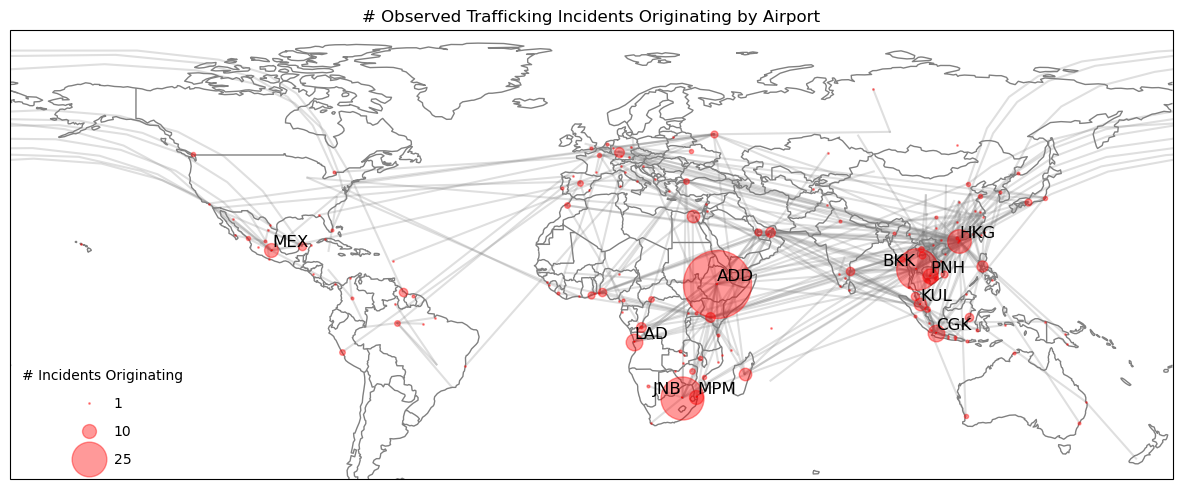

In [41]:
# Visualize Origin Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['origin_count'] > 0 or full.nodes[edge[1]]['origin_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['origin_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['origin_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['origin_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Originating")

# Set title
ax.set_title("# Observed Trafficking Incidents Originating by Airport")

# Show map
plt.show()

#### Transit Counts

In [42]:
# Count the number of times each city appears in any of the TransityCity columns 1-4
transit_cities = pd.concat([new_routes_df['transit1_iata'], new_routes_df['transit2_iata'], new_routes_df['transit3_iata'], new_routes_df['transit4_iata']], axis=0)
transit_cities.value_counts()

# Add the transit counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in transit_cities.value_counts() and node in iata_counts_list:
        full.nodes[node]['transit_count'] = (transit_cities.value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Transit Location'].iloc[0])
    elif node in transit_cities.value_counts() and node not in iata_counts_list:
        full.nodes[node]['transit_count'] = transit_cities.value_counts()[node]
    elif node not in transit_cities.value_counts() and node in iata_counts_list:
        full.nodes[node]['transit_count'] = iata_counts[iata_counts['IATA'] == node]['Transit Location'].iloc[0]
    else:
        full.nodes[node]['transit_count'] = 0

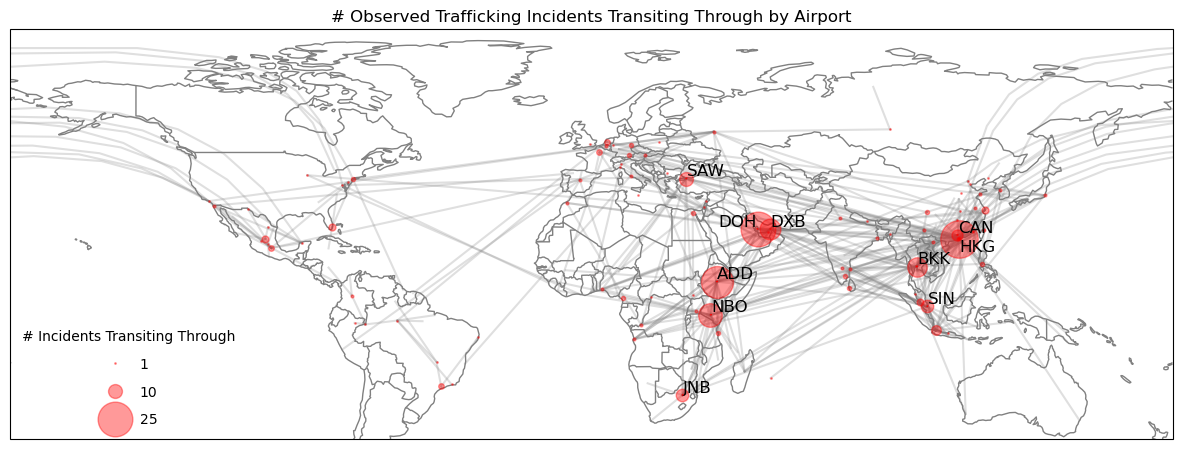

In [43]:
# Visualize Transit Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['transit_count'] > 0 or full.nodes[edge[1]]['transit_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['transit_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['transit_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['transit_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Transiting Through")

# Set title
ax.set_title("# Observed Trafficking Incidents Transiting Through by Airport")

# Show map
plt.show()

#### Destination Counts

In [24]:
new_routes_df['destination_iata'].value_counts()

# Add the transit counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in new_routes_df['destination_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['destination_count'] = (new_routes_df['destination_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Destination Location'].iloc[0])
    elif node in new_routes_df['destination_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['destination_count'] = new_routes_df['destination_iata'].value_counts()[node]
    elif node not in new_routes_df['destination_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['destination_count'] = iata_counts[iata_counts['IATA'] == node]['Destination Location'].iloc[0]
    else:
        full.nodes[node]['destination_count'] = 0

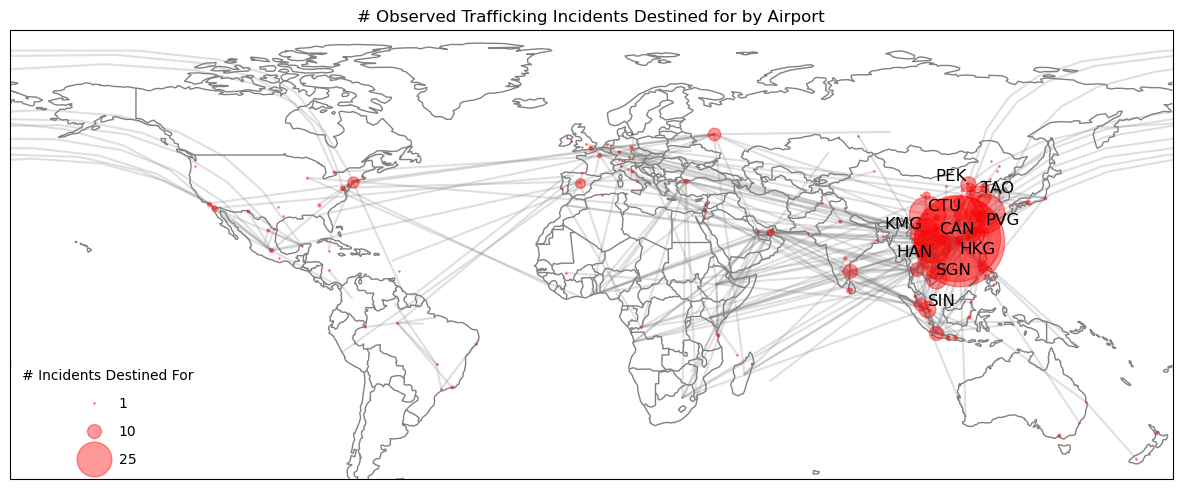

In [25]:
# Visualize Destination Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['destination_count'] > 0 or full.nodes[edge[1]]['destination_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['destination_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['destination_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['destination_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Destined For")

# Set title
ax.set_title("# Observed Trafficking Incidents Destined for by Airport")

# Show map
plt.show()

#### Seizure Counts

In [26]:
new_routes_df['seizure_iata'].value_counts()

# Add the seizure counts associated to each node in the full flight network equal to its value count
full_nodes = full.nodes()
for node in full_nodes:
    if node in new_routes_df['seizure_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['seizure_count'] = (new_routes_df['seizure_iata'].value_counts()[node] + iata_counts[iata_counts['IATA'] == node]['Discovery Location'].iloc[0])
    elif node in new_routes_df['seizure_iata'].value_counts() and node not in iata_counts_list:
        full.nodes[node]['seizure_count'] = new_routes_df['seizure_iata'].value_counts()[node]
    elif node not in new_routes_df['seizure_iata'].value_counts() and node in iata_counts_list:
        full.nodes[node]['seizure_count'] = iata_counts[iata_counts['IATA'] == node]['Discovery Location'].iloc[0]
    else:
        full.nodes[node]['seizure_count'] = 0

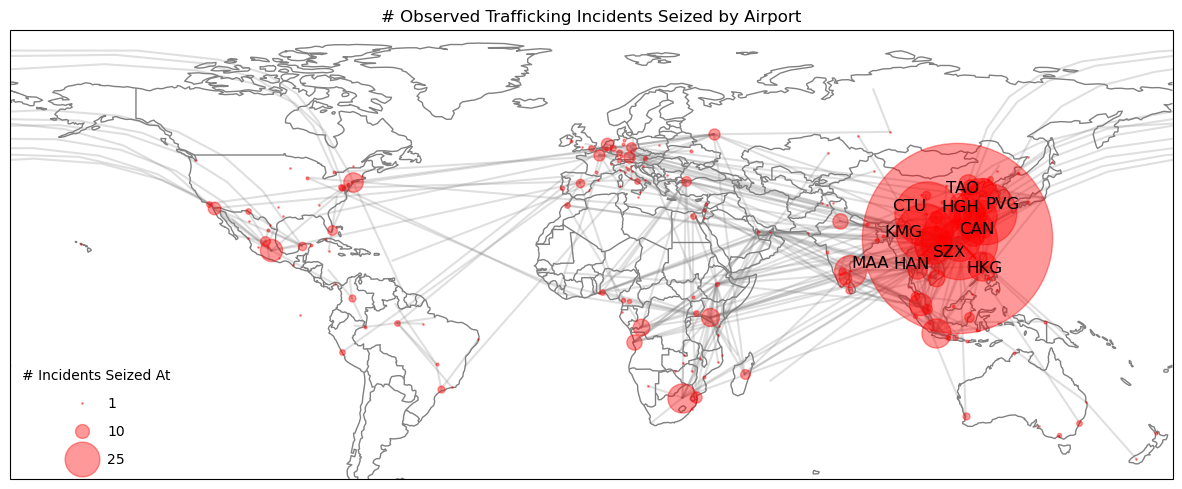

In [27]:
# Visualize Origin Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['seizure_count'] > 0 or full.nodes[edge[1]]['seizure_count'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['seizure_count'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['seizure_count']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['seizure_count'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents Seized At")

# Set title
ax.set_title("# Observed Trafficking Incidents Seized by Airport")

# Show map
plt.show()

#### Overall Counts

In [130]:
# Create a count for each node in full_nodes that counts the number of rows it appears in. If 'CAN' is listed twice in one row, only count it once.

# # For each row in new_routes_df, return the unique IATAs in the IATA columns
# unique_iatas = new_routes_df[['origin_iata', 'transit1_iata', 'transit2_iata', 'transit3_iata', 'transit4_iata', 'destination_iata'
#                               , 'seizure_iata'
#                               ]].apply(lambda x: x.unique(), axis=1)
# unique_iatas = unique_iatas.apply(lambda x: [i for i in x if i is not None])

# # Loop through unique_iatas, create a running sum of how mnay times each iata is mentioned
# iata_count = {}
# for iata_list in unique_iatas:
#     for iata in iata_list:
#         if iata in iata_count:
#             iata_count[iata] += 1
#         else:
#             iata_count[iata] = 1

# count how many times each IATA appears in combined and put it in a dictionary iata_count
iata_count = {}
for i, row in new_routes_df.iterrows():
    for iata in row['combined']:
        if iata in iata_count:
            iata_count[iata] += 1
        else:
            iata_count[iata] = 1

# Incoporating the new values from iata_counts, add these values to a feature in full.nodes() -- This is done because new_routes_df only contains data until 2020/2021, whereas iata_counts includes data from that point through 2023.
full_nodes = full.nodes()
for node in full_nodes:
    if node in iata_count and node in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_count[node] + iata_counts[iata_counts['IATA'] == node]['Report ID'].iloc[0]
    elif node in iata_count and node not in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_count[node]
    elif node not in iata_count and node in iata_counts_list:
        full.nodes[node]['incident_counts'] = iata_counts[iata_counts['IATA'] == node]['Report ID'].iloc[0]
    else:
        full.nodes[node]['incident_counts'] = 0

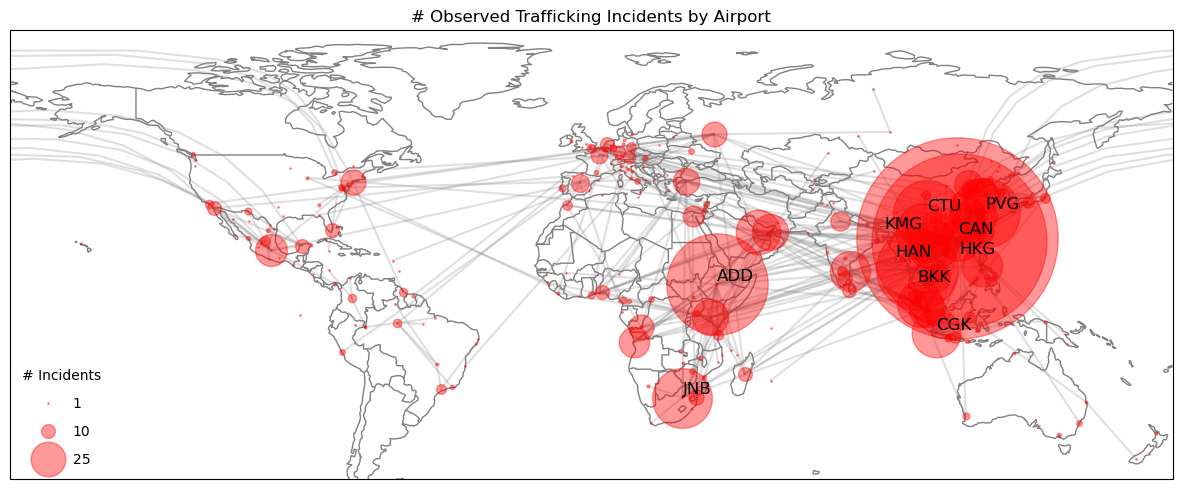

In [131]:
# Visualize Airports
scaling_factor = 100
fig, ax = plt.subplots(figsize = (15,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# Define a function to plot the geodesic path for Asia to North America flights
def plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha):
    ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=alpha, transform=ccrs.Geodetic())

# Only plot edges that are present coming from nodes with a non-zero origin_count
for edge in seizure.edges():
    if full.nodes[edge[0]]['incident_counts'] > 0 or full.nodes[edge[1]]['incident_counts'] > 0:
        start_node = seizure.nodes[edge[0]]
        end_node = seizure.nodes[edge[1]]
        start_lon, start_lat = start_node['longitude'], start_node['latitude']
        end_lon, end_lat = end_node['longitude'], end_node['latitude']
        
        # Check if the flight is between Asia and North America
        if (start_lon > 100 and end_lon < -60) or (start_lon < -60 and end_lon > 100):
            plot_geodesic_path(start_lon, start_lat, end_lon, end_lat, alpha=0.25)
        else:
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='gray', alpha=0.25)

# Loop through full.nodes() and plot any node with an observed_count > 0 with a size correspoinding to observed_count
for node in full.nodes():
    if full.nodes[node]['incident_counts'] > 0:
        lon, lat = full.nodes[node]['longitude'], full.nodes[node]['latitude']
        size = full.nodes[node]['incident_counts']
        ax.plot(lon, lat, 'ro', markersize=size, alpha=0.4)

# Label the top 10 nodes on the map based on their observed_count
top_nodes = sorted(full.nodes(), key=lambda x: full.nodes[x]['incident_counts'], reverse=True)[:10]
labels = [node for node in top_nodes]
texts = [ax.text(seizure.nodes[node]['longitude'], seizure.nodes[node]['latitude'], label, fontsize=12, ha='left', va='bottom', transform=ccrs.PlateCarree()) for node, label in zip(top_nodes, labels)]
adjust_text(texts, expand_text=(1.05, 1.05), expand_points=(1.05, 1.05), arrowprops=dict(arrowstyle='-', color='red'))

# Add size legend with name "# Trafficking Incidents Originating"
sizes = [1,10,25]
for size in sizes:
    ax.plot([], [], 'ro', markersize=size, alpha = 0.4, label=str(size))
ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="# Incidents")

# Set title
ax.set_title("# Observed Trafficking Incidents by Airport")

# Show map
plt.show()

In [30]:
new_routes_df.to_csv('new_routes_df.csv')

### National-Level Observations Analysis

In [175]:
# Initialize Dataset
data = []

# Useable Airports (even if they aren't in the useable seizure network)
nodes_with_incidents = {node: data for node, data in full.nodes(data=True) if data.get('incident_counts', 0) > 0}
nodes_with_incidents 

# Iterate over the nodes in the seizure network and extract the country, degree, betweenness, degree_in, degree_out, and observed_count
for node in nodes_with_incidents: 
    country = full.nodes[node]['country']
    observed_count = full.nodes[node]['incident_counts']
    origin_count = full.nodes[node]['origin_count']
    transit_count = full.nodes[node]['transit_count']
    destination_count = full.nodes[node]['destination_count']
    seizure_count = full.nodes[node]['seizure_count']
    if node in seizure.nodes:
        degree_seizure = seizure.nodes[node]['degree_seizure']
        between_seizure = seizure.nodes[node]['between_seizure']
    data.append({'Country': country, 'Node': node, 'Degree': degree_seizure, 'Betweenness': between_seizure, 'Incident_count': observed_count, 'Origin_count': origin_count, 'Transit_count': transit_count, 'Destination_count': destination_count, 'Seizure_count': seizure_count})

airport_df = pd.DataFrame(data)
airport_df = airport_df.sort_values(by=['Country', 'Degree'], ascending=[True, False])
airport_df['Country'] = airport_df['Country'].str.title()

airport_df

Country Node    Degree  Betweenness  Incident_count  Origin_count  \
202    Albania  TIA  0.004405     0.000000               1           1.0   
133    Algeria  ALG  0.004405     0.000000               1           0.0   
223     Angola  LAD  0.030837     0.037794              22          12.0   
32   Australia  DRW  0.066079     0.019689               2           2.0   
41   Australia  PER  0.008811     0.000000               5           3.0   
..         ...  ...       ...          ...             ...           ...   
275    Vietnam  DAD  0.004405     0.000000               1           1.0   
251     Zambia  LVI  0.008811     0.000000               1           1.0   
249     Zambia  LUN  0.004405     0.000000               2           1.0   
288     Zambia  NLA  0.004405     0.000000               1           1.0   
234   Zimbabwe  HRE  0.008811     0.000000               4           4.0   

     Transit_count  Destination_count  Seizure_count  
202            0.0                0.0            0.0  
133            0.0                1.0            0.0  
223            2.0                0.0           11.0  
32             0.0                0.0            2.0  
41             0.0                0.0            5.0  
..             ...                ...            ...  
275            0.0                0.0            0.0  
251            0.0                0.0            1.0  
249            0.0                0.0            1.0  
288            0.0                0.0            1.0  
234            0.0                0.0            1.0  

[311 rows x 9 columns]

In [211]:
# Use UN to Group Countries into Regions, Subregions, and Continents
subregional_mapping = {
    'Congo (Brazzaville)': 'Sub-Saharan Africa',
    'Barbados': 'Latin America & Caribbean',
    'Hong Kong': 'East Asia',
    'Ethiopia': 'Sub-Saharan Africa',
    'Qatar': 'West Asia',
    'Kenya': 'Sub-Saharan Africa',
    'United Arab Emirates': 'West Asia',
    'Turkey': 'West Asia',
    'South Africa': 'Sub-Saharan Africa',
    'Singapore': 'South-East Asia',
    'Indonesia': 'South-East Asia',
    'Thailand': 'South-East Asia',
    'Mexico': 'Latin America & Caribbean',
    'Netherlands': 'Western Europe',
    'France': 'Western Europe',
    'Malaysia': 'South-East Asia',
    'Germany': 'Western Europe',
    'Sri Lanka': 'South Asia',
    'Spain': 'Western Europe',
    'China': 'East Asia',
    'Congo (Kinshasa)': 'Sub-Saharan Africa',
    'Macau': 'East Asia',
    'Italy': 'Western Europe',
    'Japan': 'East Asia',
    'India': 'South Asia',
    'United States': 'Others',
    'Belgium': 'Western Europe',
    'South Korea': 'East Asia',
    'Russia': 'Eastern Europe',
    'Morocco': 'Sub-Saharan Africa',
    'Lebanon': 'West Asia',
    'Bulgaria': 'Eastern Europe',
    'Brazil': 'Latin America & Caribbean',
    'United Kingdom': 'Western Europe',
    'Reunion': 'Sub-Saharan Africa',
    'Nepal': 'South Asia',
    'South Sudan': 'Sub-Saharan Africa',
    'Vietnam': 'South-East Asia',
    'Colombia': 'Latin America & Caribbean',
    'Egypt': 'Sub-Saharan Africa',
    'Philippines': 'South-East Asia',
    'Taiwan': 'East Asia',
    'Angola': 'Sub-Saharan Africa',
    'Peru': 'Latin America & Caribbean',
    'Tanzania': 'Sub-Saharan Africa',
    'Cameroon': 'Sub-Saharan Africa',
    'Austria': 'Western Europe',
    'Cambodia': 'South-East Asia',
    'Mozambique': 'Sub-Saharan Africa',
    'Madagascar': 'Sub-Saharan Africa',
    'Nigeria': 'Sub-Saharan Africa',
    'Ecuador': 'Latin America & Caribbean',
    'Guyana': 'Latin America & Caribbean',
    'Ghana': 'Sub-Saharan Africa',
    'Laos': 'South-East Asia',
    'Zimbabwe': 'Sub-Saharan Africa',
    'Burma': 'South-East Asia',
    'Canada': 'Others',
    'Central African Republic': 'Sub-Saharan Africa',
    'Malawi': 'Sub-Saharan Africa',
    'Australia': 'Others',
    'Ukraine': 'Eastern Europe',
    'Liberia': 'Sub-Saharan Africa',
    'Portugal': 'Western Europe',
    'Uganda': 'Sub-Saharan Africa',
    'Suriname': 'Latin America & Caribbean',
    'Namibia': 'Sub-Saharan Africa',
    'Zambia': 'Sub-Saharan Africa',
    "Cote D'Ivoire": 'Sub-Saharan Africa',
    'Togo': 'Sub-Saharan Africa',
    'Sierra Leone': 'Sub-Saharan Africa',
    'Comoros': 'Sub-Saharan Africa',
    'Albania': 'Eastern Europe',
    'Jordan': 'West Asia',
    'Kazakhstan': 'West Asia',
    'Equatorial Guinea': 'Sub-Saharan Africa',
    'Greece': 'Western Europe',
    'Gabon': 'Sub-Saharan Africa',
    'Pakistan': 'South Asia',
    'Croatia': 'Eastern Europe',
    'Cuba': 'Latin America & Caribbean',
    'Seychelles': 'Sub-Saharan Africa',
    'Benin': 'Sub-Saharan Africa',
    'Guadeloupe': 'Latin America & Caribbean',
    'Guinea': 'Sub-Saharan Africa',
    'Panama': 'Latin America & Caribbean',
    'Papua New Guinea': 'Others',
    'Tajikistan': 'West Asia',
    'Lithuania': 'Eastern Europe',
    'New Zealand': 'Others',
    'Israel': 'West Asia',
    'Denmark': 'Western Europe',
    'Mayotte': 'Sub-Saharan Africa',
    'Cayman Islands': 'Latin America & Caribbean',
    'Mali': 'Sub-Saharan Africa',
    'Uzbekistan': 'West Asia',
    'Ireland': 'Western Europe',
    'Switzerland': 'Western Europe',
    'Algeria': 'Sub-Saharan Africa',
    'Bangladesh': 'South Asia',
    'Poland': 'Western Europe',
    'Malta': 'Others',
    'Nicaragua': 'Latin America & Caribbean'
}

country_continent_mapping = {
    'Congo (Brazzaville)':'Africa',
    'Barbados': 'Americas',
    'Ecuador': 'Americas',
    'Hong Kong': 'Asia',
    'Ethiopia': 'Africa',
    'Qatar': 'Asia',
    'Kenya': 'Africa',
    'United Arab Emirates': 'Asia',
    'Turkey': 'Asia',
    'South Africa': 'Africa',
    'Singapore': 'Asia',
    'Indonesia': 'Asia',
    'Thailand': 'Asia',
    'Mexico': 'Americas',
    'Netherlands': 'Europe',
    'France': 'Europe',
    'Malaysia': 'Asia',
    'Germany': 'Europe',
    'Sri Lanka': 'Asia',
    'Spain': 'Europe',
    'China': 'Asia',
    'Congo (Kinshasa)': 'Africa',
    'Macau': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'India': 'Asia',
    'United States': 'Americas',
    'Belgium': 'Europe',
    'South Korea': 'Asia',
    'Russia': 'Europe',
    'Morocco': 'Africa',
    'Lebanon': 'Asia',
    'Bulgaria': 'Europe',
    'Brazil': 'Americas',
    'United Kingdom': 'Europe',
    'Reunion': 'Africa',
    'Nepal': 'Asia',
    'South Sudan': 'Africa',
    'Vietnam': 'Asia',
    'Colombia': 'Americas',
    'Egypt': 'Africa',
    'Philippines': 'Asia',
    'Taiwan': 'Asia',
    'Angola': 'Africa',
    'Peru': 'Americas',
    'Tanzania': 'Africa',
    'Cameroon': 'Africa',
    'Austria': 'Europe',
    'Cambodia': 'Asia',
    'Mozambique': 'Africa',
    'Madagascar': 'Africa',
    'Nigeria': 'Africa',
    'Guyana': 'Americas',
    'Ghana': 'Africa',
    'Laos': 'Asia',
    'Zimbabwe': 'Africa',
    'Burma': 'Asia',
    'Canada': 'Americas',
    'Central African Republic': 'Africa',
    'Malawi': 'Africa',
    'Australia': 'Oceania',
    'Ukraine': 'Europe',
    'Liberia': 'Africa',
    'Portugal': 'Europe',
    'Uganda': 'Africa',
    'Suriname': 'Americas',
    'Namibia': 'Africa',
    'Zambia': 'Africa',
    "Cote D'Ivoire": 'Africa',
    'Togo': 'Africa',
    'Sierra Leone': 'Africa',
    'Comoros': 'Africa',
    'Albania': 'Europe',
    'Jordan': 'Asia',
    'Kazakhstan': 'Asia',
    'Equatorial Guinea': 'Africa',
    'Greece': 'Europe',
    'Gabon': 'Africa',
    'Pakistan': 'Asia',
    'Croatia': 'Europe',
    'Cuba': 'Americas',
    'Seychelles': 'Africa',
    'Benin': 'Africa',
    'Guadeloupe': 'Americas',
    'Guinea': 'Africa',
    'Panama': 'Americas',
    'Papua New Guinea': 'Oceania',
    'Tajikistan': 'Asia',
    'Lithuania': 'Europe',
    'New Zealand': 'Oceania',
    'Israel': 'Asia',
    'Denmark': 'Europe',
    'Mayotte': 'Africa',
    'Cayman Islands': 'Americas',
    'Mali': 'Africa',
    'Uzbekistan': 'Asia',
    'Ireland': 'Europe',
    'Switzerland': 'Europe',
    'Algeria': 'Africa',
    'Bangladesh': 'Asia',
    'Poland': 'Europe',
    'Malta': 'Europe',
    'Nicaragua': 'Americas'
}

airport_df['Continent'] = airport_df['Country'].map(country_continent_mapping)
airport_df['Subregion'] = airport_df['Country'].map(subregional_mapping)

airport_df

Country Node    Degree  Betweenness  Incident_count  Origin_count  \
202    Albania  TIA  0.004405     0.000000               1           1.0   
133    Algeria  ALG  0.004405     0.000000               1           0.0   
223     Angola  LAD  0.030837     0.037794              22          12.0   
32   Australia  DRW  0.066079     0.019689               2           2.0   
41   Australia  PER  0.008811     0.000000               5           3.0   
..         ...  ...       ...          ...             ...           ...   
275    Vietnam  DAD  0.004405     0.000000               1           1.0   
251     Zambia  LVI  0.008811     0.000000               1           1.0   
249     Zambia  LUN  0.004405     0.000000               2           1.0   
288     Zambia  NLA  0.004405     0.000000               1           1.0   
234   Zimbabwe  HRE  0.008811     0.000000               4           4.0   

     Transit_count  Destination_count  Seizure_count  Path_Total_Count  \
202            0.0                0.0            0.0               1.0   
133            0.0                1.0            0.0               1.0   
223            2.0                0.0           11.0              14.0   
32             0.0                0.0            2.0               2.0   
41             0.0                0.0            5.0               3.0   
..             ...                ...            ...               ...   
275            0.0                0.0            0.0               1.0   
251            0.0                0.0            1.0               1.0   
249            0.0                0.0            1.0               1.0   
288            0.0                0.0            1.0               1.0   
234            0.0                0.0            1.0               4.0   

     Origin_Percentage  Transit_Percentage  Destination_Percentage Continent  \
202           1.000000            0.000000                     0.0    Europe   
133           0.000000            0.000000                     1.0    Africa   
223           0.857143            0.142857                     0.0    Africa   
32            1.000000            0.000000                     0.0   Oceania   
41            1.000000            0.000000                     0.0   Oceania   
..                 ...                 ...                     ...       ...   
275           1.000000            0.000000                     0.0      Asia   
251           1.000000            0.000000                     0.0    Africa   
249           1.000000            0.000000                     0.0    Africa   
288           1.000000            0.000000                     0.0    Africa   
234           1.000000            0.000000                     0.0    Africa   

              Subregion  
202      Eastern Europe  
133  Sub-Saharan Africa  
223  Sub-Saharan Africa  
32               Others  
41               Others  
..                  ...  
275     South-East Asia  
251  Sub-Saharan Africa  
249  Sub-Saharan Africa  
288  Sub-Saharan Africa  
234  Sub-Saharan Africa  

[311 rows x 15 columns]

In [176]:
# Apply Country Mappings to be loaded into map
custom_mappings = {
    'Burma': 'Myanmar',
    'Congo (Brazzaville)': 'Congo',
    "Cote D'Ivoire": "Côte d'Ivoire",
    'Central African Republic': 'Central African Rep.',
    'Congo (Kinshasa)': 'Dem. Rep. Congo',
    'Equatorial Guinea': 'Eq. Guinea',
    # 'Hong Kong': 'China',
    # 'Macau': 'China',
    'South Sudan': 'S. Sudan',
    'United States': 'United States of America',
}

# Apply the custom mapping to create a new column in country_df
airport_df['Country'] = airport_df['Country'].apply(lambda x: custom_mappings.get(x, x))
airport_df

Country Node    Degree  Betweenness  Incident_count  Origin_count  \
202    Albania  TIA  0.004405     0.000000               1           1.0   
133    Algeria  ALG  0.004405     0.000000               1           0.0   
223     Angola  LAD  0.030837     0.037794              22          12.0   
32   Australia  DRW  0.066079     0.019689               2           2.0   
41   Australia  PER  0.008811     0.000000               5           3.0   
..         ...  ...       ...          ...             ...           ...   
275    Vietnam  DAD  0.004405     0.000000               1           1.0   
251     Zambia  LVI  0.008811     0.000000               1           1.0   
249     Zambia  LUN  0.004405     0.000000               2           1.0   
288     Zambia  NLA  0.004405     0.000000               1           1.0   
234   Zimbabwe  HRE  0.008811     0.000000               4           4.0   

     Transit_count  Destination_count  Seizure_count  
202            0.0                0.0            0.0  
133            0.0                1.0            0.0  
223            2.0                0.0           11.0  
32             0.0                0.0            2.0  
41             0.0                0.0            5.0  
..             ...                ...            ...  
275            0.0                0.0            0.0  
251            0.0                0.0            1.0  
249            0.0                0.0            1.0  
288            0.0                0.0            1.0  
234            0.0                0.0            1.0  

[311 rows x 9 columns]

### Country-Level Role Type Visualizations

#### Origin

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_29742/3902385099.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


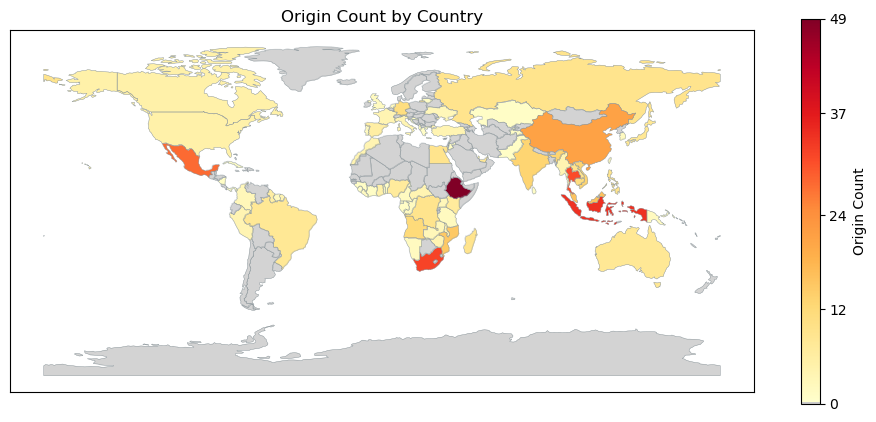

In [178]:
# Sum incidents by country
sum_origin_by_country = airport_df.groupby('Country')['Origin_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_origin_by_country, how='left', left_on='name', right_on='Country')
world['Origin_count'] = world['Origin_count'].fillna(0)

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Origin_count'].max()
min_value = world['Origin_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1]
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha=0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Origin_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Origin_count']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, ticks=tick_positions)
cbar.set_label('Origin Count')

# Show map
ax.set_title('Origin Count by Country')
plt.show()


#### Transit

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_29742/187457918.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


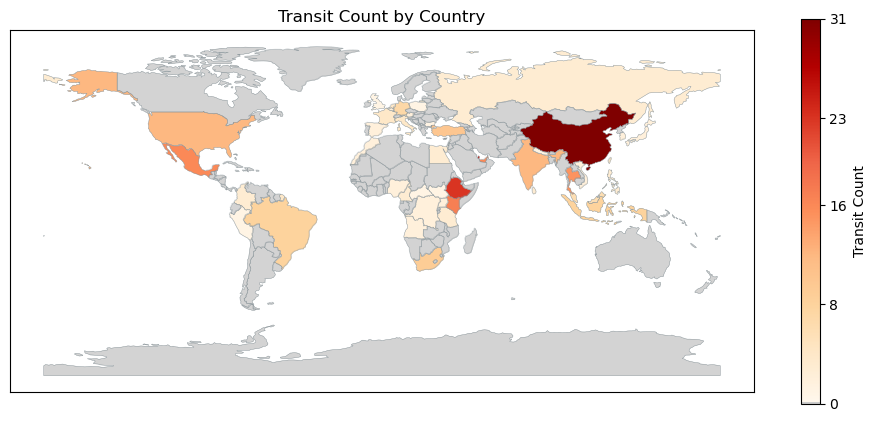

In [179]:
# INCLUDE CHINA 

# Add all the incidents occuring at airports for each country
sum_transit_by_country = airport_df.groupby('Country')['Transit_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_transit_by_country, how='left', left_on='name', right_on='Country')
world['Transit_count'] = world['Transit_count'].fillna(0)

# Create a color map where the first color is grey for zero values
# Using 'OrRd' colormap for non-zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Transit_count'].max()
min_value = world['Transit_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Transit_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Transit_count']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Transit_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Transit Count')

# Show map
ax.set_title('Transit Count by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2142460474.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2142460474.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


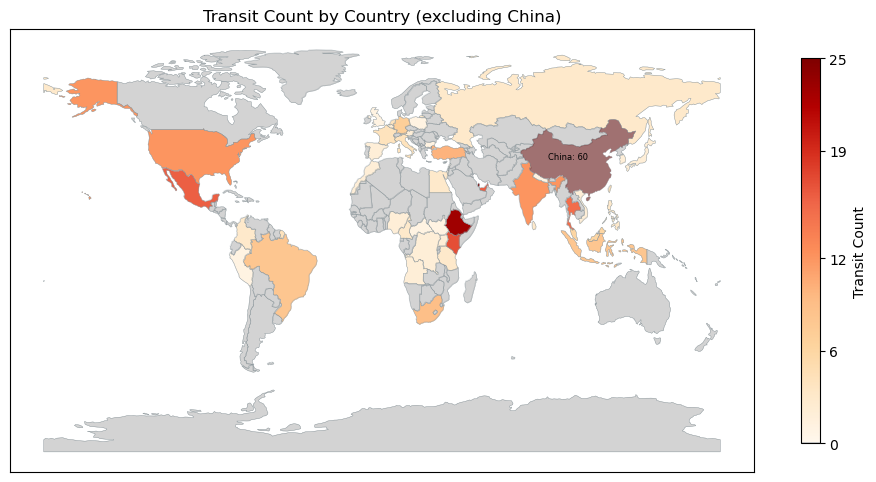

In [1213]:
### EXCLUDE CHINA

# Add all the incidents occuring at airports for each country
sum_transit_by_country = airport_df.groupby('Country')['Transit_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_transit_by_country, how='left', left_on='name', right_on='Country')
world['Transit_count'] = world['Transit_count'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = int(china['Transit_count'].values[0])
# remove china, hong kong, and macau
world_without_china = world[world['name'] != 'China'] 

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world_without_china['Transit_count'].max()
min_value = world_without_china['Transit_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Transit_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Transit_count']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Transit_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Transit Count')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Add custom legend for China
# china_patch = mpatches.Patch(color='#814141', label=f'China = {china_value}', edgecolor = 'none')
# ax.legend(handles=[china_patch], loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Show Map
ax.set_title('Transit Count by Country (excluding China)')
plt.show()

#### Destination

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2501470454.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


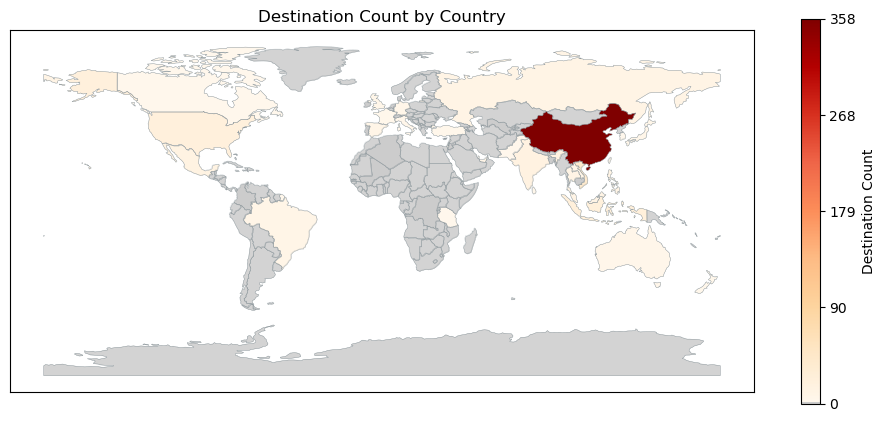

In [1215]:
### INCLUDING CHINA

# Add all the incidents occuring at airports for each country
sum_dest_by_country = airport_df.groupby('Country')['Destination_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_dest_by_country, how='left', left_on='name', right_on='Country')
world['Destination_count'] = world['Destination_count'].fillna(0)

# Create a color map where the first color is grey for zero values
# Using 'OrRd' colormap for non-zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Destination_count'].max()
min_value = world['Destination_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Destination_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Destination_count']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Destination_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Destination Count')

# Show map
ax.set_title('Destination Count by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/482897694.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/482897694.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


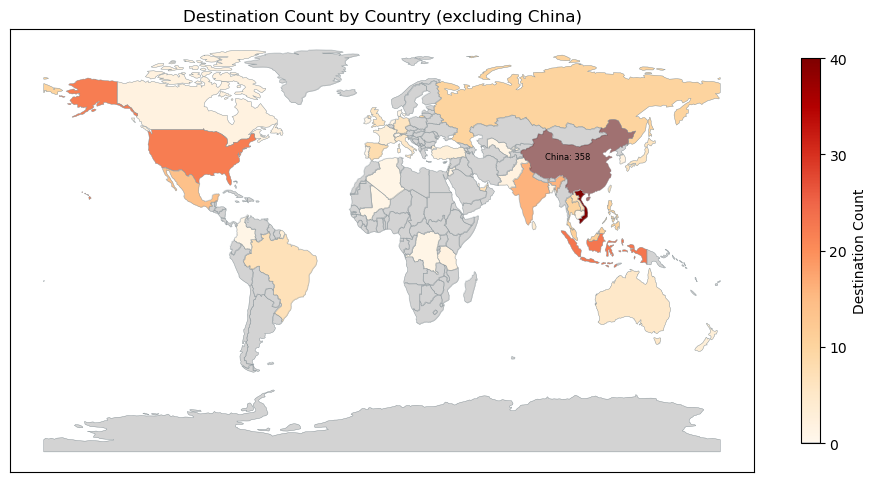

In [1216]:
### EXCLUDE CHINA

# Add all the incidents occuring at airports for each country
sum_dest_by_country = airport_df.groupby('Country')['Destination_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_dest_by_country, how='left', left_on='name', right_on='Country')
world['Destination_count'] = world['Destination_count'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = int(china['Destination_count'].values[0])
world_without_china = world[world['name'] != 'China']

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world_without_china['Destination_count'].max()
min_value = world_without_china['Destination_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Destination_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Destination_count']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Destination_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Destination Count')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Show Map
ax.set_title('Destination Count by Country (excluding China)')
plt.show()


#### Seizure

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/4093457804.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


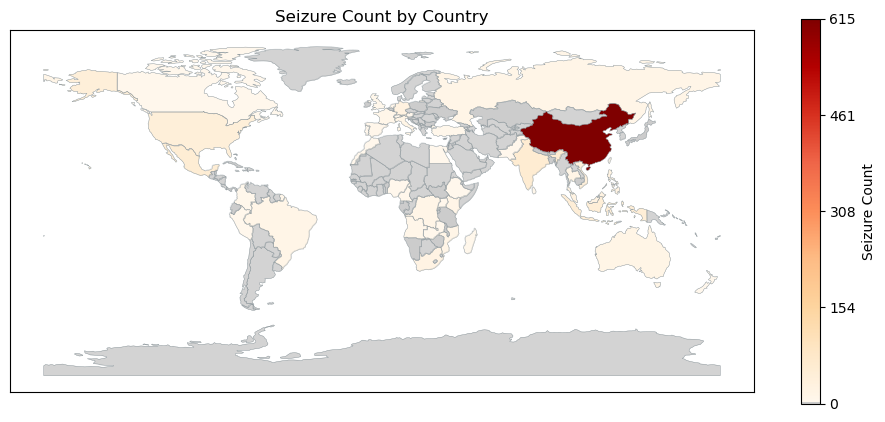

In [1217]:
### INCLUDING CHINA
sum_seizure_by_country = airport_df.groupby('Country')['Seizure_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_seizure_by_country, how='left', left_on='name', right_on='Country')
world['Seizure_count'] = world['Seizure_count'].fillna(0)

# Create a color map where the first color is grey for zero values
# Using 'OrRd' colormap for non-zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Seizure_count'].max()
min_value = world['Seizure_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Seizure_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Seizure_count']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Seizure_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Seizure Count')

# Show map
ax.set_title('Seizure Count by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2865342904.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2865342904.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


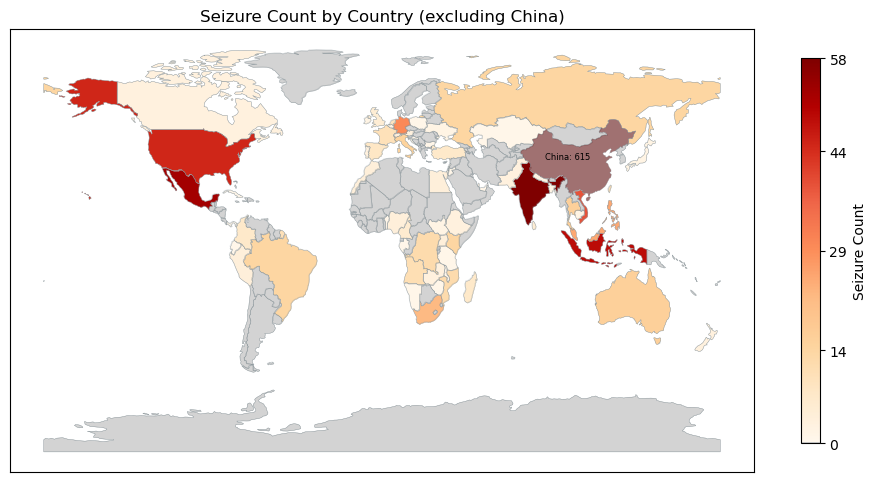

In [1218]:
### EXCLUDE CHINA
sum_seizure_by_country = airport_df.groupby('Country')['Seizure_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(sum_seizure_by_country, how='left', left_on='name', right_on='Country')
world['Seizure_count'] = world['Seizure_count'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = int(china['Seizure_count'].values[0])
world_without_china = world[world['name'] != 'China']

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world_without_china['Seizure_count'].max()
min_value = world_without_china['Seizure_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Seizure_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Seizure_count']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Seizure_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Seizure Count')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Show Map
ax.set_title('Seizure Count by Country (excluding China)')
plt.show()


#### Incident Counts

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_29742/100936154.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


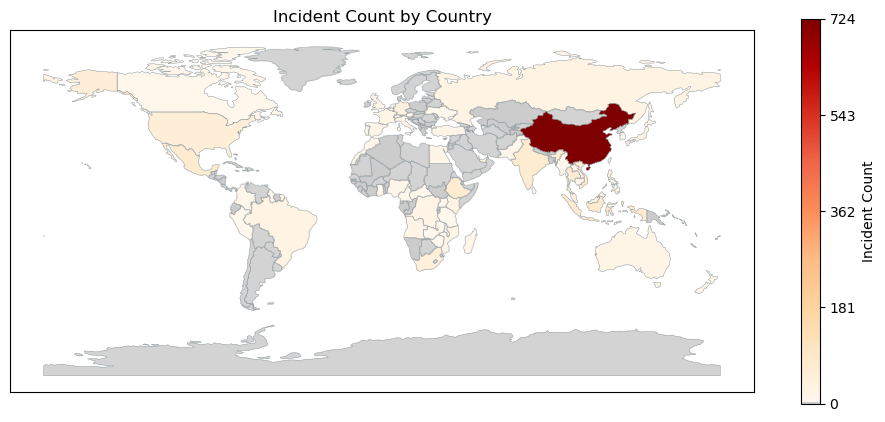

In [173]:
### INCLUDING CHINA
observed_count_by_country = airport_df.groupby('Country')['Incident_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(observed_count_by_country, how='left', left_on='name', right_on='Country')
world['Incident_count'] = world['Incident_count'].fillna(0)

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Incident_count'].max()
min_value = world['Incident_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Incident_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Incident_count']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Incident_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Incident Count')

# Show map
ax.set_title('Incident Count by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_29742/36199231.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_29742/36199231.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


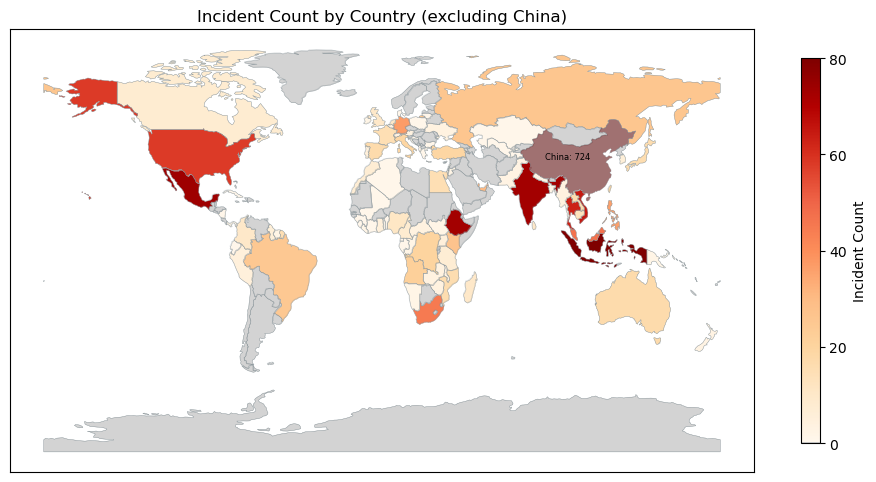

In [174]:
### EXCLUDE CHINA
observed_count_by_country = airport_df.groupby('Country')['Incident_count'].sum().reset_index()

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(observed_count_by_country, how='left', left_on='name', right_on='Country')
world['Incident_count'] = world['Incident_count'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = int(china['Incident_count'].values[0])
world_without_china = world[world['name'] != 'China']

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world_without_china['Incident_count'].max()
min_value = world_without_china['Incident_count'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values).astype(int)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Incident_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Incident_count']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Incident_count'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Incident Count')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Show Map
ax.set_title('Incident Count by Country (excluding China)')
plt.show()


In [191]:
airport_df['Country'].nunique()

103

#### Seizure Rates

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/1576513250.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


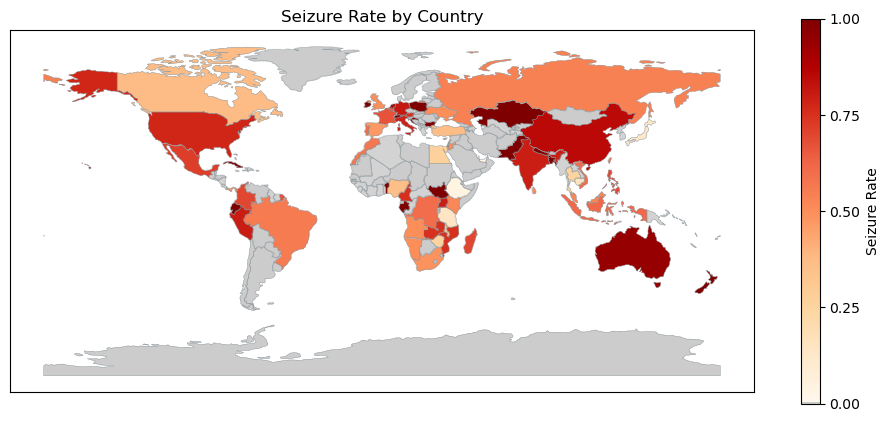

In [1221]:
# Calculate seizure rate
country_counts = airport_df.groupby('Country').agg({'Incident_count': 'sum', 'Seizure_count': 'sum'}).reset_index()
country_counts['Seizure_rate'] = country_counts['Seizure_count'] / country_counts['Incident_count']

# Merge world map with your DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(country_counts, how='left', left_on='name', right_on='Country')
world['Seizure_rate'] = world['Seizure_rate'].fillna(0)

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = world['Seizure_rate'].max()
min_value = world['Seizure_rate'].min()
mid_values = np.linspace(min_value, max_value, 5)[1:-1] 
mid_values = np.round(mid_values,2)  # Round the values to the nearest integer
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Seizure_count'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Seizure_rate']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Seizure_rate'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Seizure Rate')

# Show Map
ax.set_title('Seizure Rate by Country')
plt.show()

### Country-Level Centrality Analysis

#### Degree Centrality

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/4229958911.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


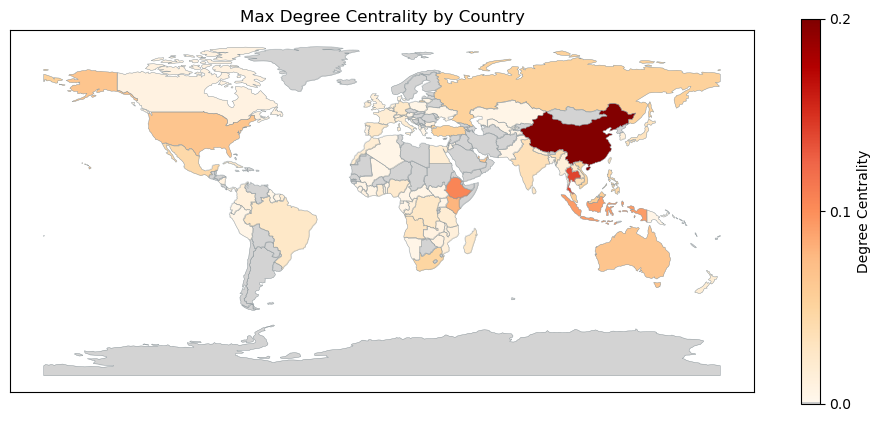

In [1222]:
### INCLUDE CHINA
max_deg_by_country = airport_df.groupby('Country')['Degree'].max().reset_index()

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(max_deg_by_country, how='left', left_on='name', right_on='Country')
world['Degree'] = world['Degree'].fillna(0)

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = np.round(world['Degree'].max(),2)
min_value = np.round(world['Degree'].min(),2)
mid_values = np.linspace(min_value, max_value, 3)[1:-1] 
mid_values = np.round(mid_values,2)
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Degree'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Degree']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Degree'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Degree Centrality')

# Show Map
ax.set_title('Max Degree Centrality by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2600451713.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/2600451713.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


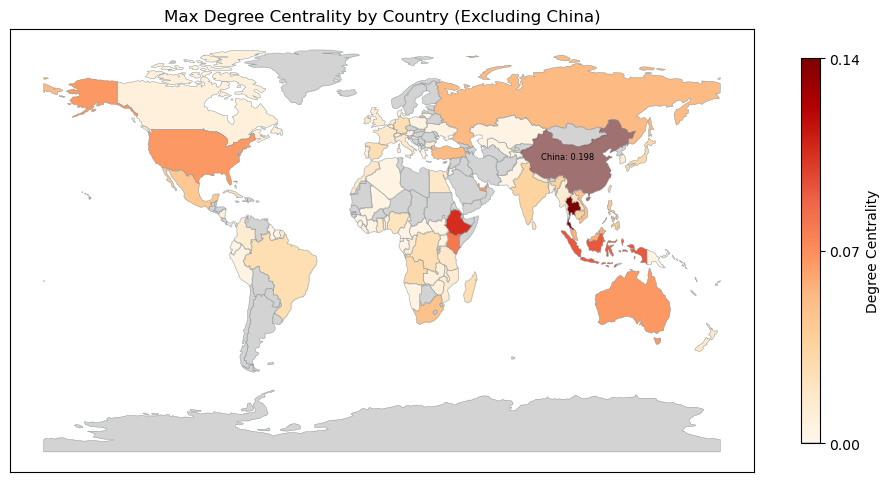

In [1223]:
### EXCLUDE CHINA
max_deg_by_country = airport_df.groupby('Country')['Degree'].max().reset_index()

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(max_deg_by_country, how='left', left_on='name', right_on='Country')
world['Degree'] = world['Degree'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = np.round(china['Degree'].values[0],3)
world_without_china = world[world['name'] != 'China']

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = np.round(world_without_china['Degree'].max(),2)
min_value = np.round(world_without_china['Degree'].min(),2)
mid_values = np.linspace(min_value, max_value, 3)[1:-1] 
mid_values = np.round(mid_values,2)
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Degree'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Degree']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Degree'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Degree Centrality')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Show Map
ax.set_title('Max Degree Centrality by Country (Excluding China)')
plt.show()

#### Betweenness Centrality

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/571733210.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


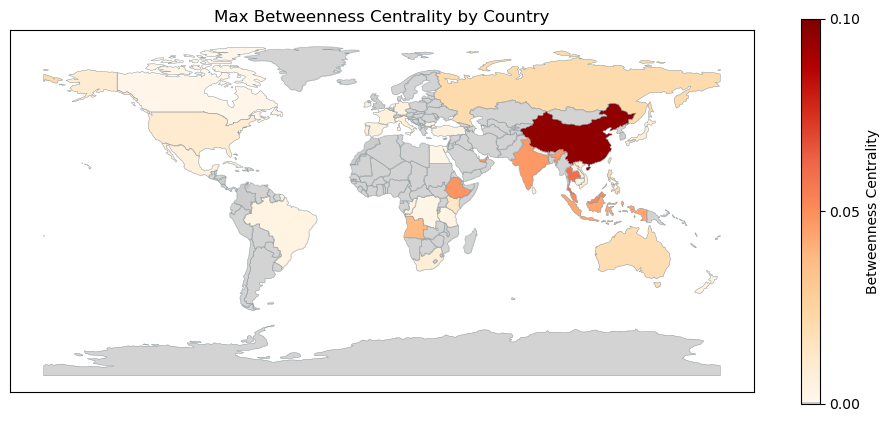

In [1224]:
### INCLUDE CHINA
max_bet_by_country = airport_df.groupby('Country')['Betweenness'].max().reset_index()

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(max_bet_by_country, how='left', left_on='name', right_on='Country')
world['Betweenness'] = world['Betweenness'].fillna(0)

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = np.round(world['Betweenness'].max(),2)
min_value = np.round(world['Betweenness'].min(),2)
mid_values = np.linspace(min_value, max_value, 3)[1:-1] 
mid_values = np.round(mid_values,2)
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world.iterrows():
    if row['Betweenness'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Betweenness']))
    world[world.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world['Betweenness'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Betweenness Centrality')

# Show Map
ax.set_title('Max Betweenness Centrality by Country')
plt.show()

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/534742041.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_51525/534742041.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  china_centroid = china.geometry.centroid.iloc[0]


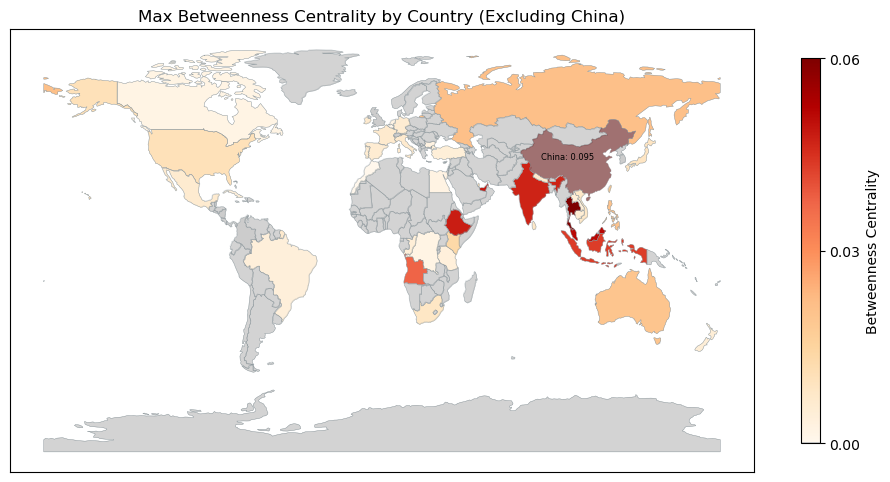

In [1225]:
### EXCLUDE CHINA
max_bet_by_country = airport_df.groupby('Country')['Betweenness'].max().reset_index()

# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(max_bet_by_country, how='left', left_on='name', right_on='Country')
world['Betweenness'] = world['Betweenness'].fillna(0)

# Separate China data
china = world[world['name'] == 'China']
china_value = np.round(china['Betweenness'].values[0],3)
world_without_china = world[world['name'] != 'China']

# Create a color map where the first color is grey for zero values
cmap = plt.get_cmap('OrRd')
colors = cmap(np.linspace(0, 1, cmap.N))
new_colors = np.vstack((np.array([0.8, 0.8, 0.8, 1]), colors))
new_cmap = mcolors.ListedColormap(new_colors)

# Determine the tick positions
max_value = np.round(world_without_china['Betweenness'].max(),2)
min_value = np.round(world_without_china['Betweenness'].min(),2)
mid_values = np.linspace(min_value, max_value, 3)[1:-1] 
mid_values = np.round(mid_values,2)
tick_positions = [min_value] + list(mid_values) + [max_value]

# Create a normalization that ignores zeros
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
world_without_china.boundary.plot(ax=ax, linewidth=0.25, edgecolor='#899499', alpha = 0.5)  # Set outline color to light grey

# Plot each country individually to handle the custom colormap
for idx, row in world_without_china.iterrows():
    if row['Betweenness'] == 0:
        color = 'lightgrey'
    else:
        color = new_cmap(norm(row['Betweenness']))
    world_without_china[world_without_china.index == idx].plot(ax=ax, color=color, edgecolor='#899499', linewidth=0.25)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add color legend
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
max_value = world_without_china['Betweenness'].max()
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.5, ticks=tick_positions)
cbar.set_label('Betweenness Centrality')

# Overlay China with a distinct outline
china.plot(ax=ax, color='#814141', edgecolor='#899499', linewidth=0.25, alpha = 0.75)
china_centroid = china.geometry.centroid.iloc[0]
plt.annotate(f"China: {china_value}", xy=(china_centroid.x-5, china_centroid.y), xycoords='data',
             fontsize=6, ha='center')

# Show Map
ax.set_title('Max Betweenness Centrality by Country (Excluding China)')
plt.show()

### Airport/Node Features EDA

In [ ]:
data = []

for node, attr in full.nodes(data=True):
    node_data = {'Node': node}
    node_data.update(attr)
    data.append(node_data)

node_df = pd.DataFrame(data)

node_feature_columns = node_df.columns[14:]

Node    id                           name             city    country  \
0     AER  2965    Sochi International Airport            Sochi     russia   
1     KZN  2990    Kazan International Airport            Kazan     russia   
2     ASF  2966              Astrakhan Airport        Astrakhan     russia   
3     MRV  2962       Mineralnyye Vody Airport  Mineralnye Vody     russia   
4     CEK  2968  Chelyabinsk Balandino Airport      Chelyabinsk     russia   
...   ...   ...                            ...              ...        ...   
1928  PKE  6317                 Parkes Airport           Parkes  australia   
1929  GFF  6271               Griffith Airport         Griffith  australia   
1930  MIM  6294              Merimbula Airport        Merimbula  australia   
1931  MYA  6302                 Moruya Airport           Moruya  australia   
1932  OAG  6793                 Orange Airport           Orange  australia   

      ICAO   latitude   longitude  altitude  timezone  ... close_full  \
0     URSS  43.449902   39.956600        89       3.0  ...   0.086599   
1     UWKD  55.606201   49.278702       411       3.0  ...   0.086629   
2     URWA  46.283298   48.006302       -65       4.0  ...   0.086629   
3     URMM  44.225101   43.081902      1054       3.0  ...   0.086629   
4     USCC  55.305801   61.503300       769       5.0  ...   0.086629   
...    ...        ...         ...       ...       ...  ...        ...   
1928  YPKS -33.131401  148.238998      1069      10.0  ...   0.082458   
1929  YGTH -34.250801  146.067001       439      10.0  ...   0.082458   
1930  YMER -36.908600  149.901001         7      10.0  ...   0.082512   
1931  YMRY -35.897800  150.143997        14      10.0  ...   0.082458   
1932  YORG -33.381699  149.132996      3115      10.0  ...   0.082458   

     eigen_full   pr_full degree_in_full  degree_out_full  origin_count  \
0      0.001129  0.000251       0.000518         0.007246           0.0   
1      0.001186  0.000266       0.001035         0.009317           0.0   
2      0.001189  0.000263       0.001035         0.003106           0.0   
3      0.001189  0.000288       0.001035         0.006211           0.0   
4      0.001189  0.000263       0.001035         0.005176           0.0   
...         ...       ...            ...              ...           ...   
1928   0.000626  0.000254       0.000518         0.000000           0.0   
1929   0.000626  0.000254       0.000518         0.000000           0.0   
1930   0.001271  0.000265       0.001035         0.000000           0.0   
1931   0.000626  0.000254       0.000518         0.000000           0.0   
1932   0.000626  0.000254       0.000518         0.000000           0.0   

      transit_count  destination_count  seizure_count  incident_counts  
0               0.0                0.0            0.0                0  
1               0.0                0.0            0.0                0  
2               0.0                0.0            0.0                0  
3               0.0                0.0            0.0                0  
4               0.0                0.0            0.0                0  
...             ...                ...            ...              ...  
1928            0.0                0.0            0.0                0  
1929            0.0                0.0            0.0                0  
1930            0.0                0.0            0.0                0  
1931            0.0                0.0            0.0                0  
1932            0.0                0.0            0.0                0  

[1933 rows x 62 columns]

/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

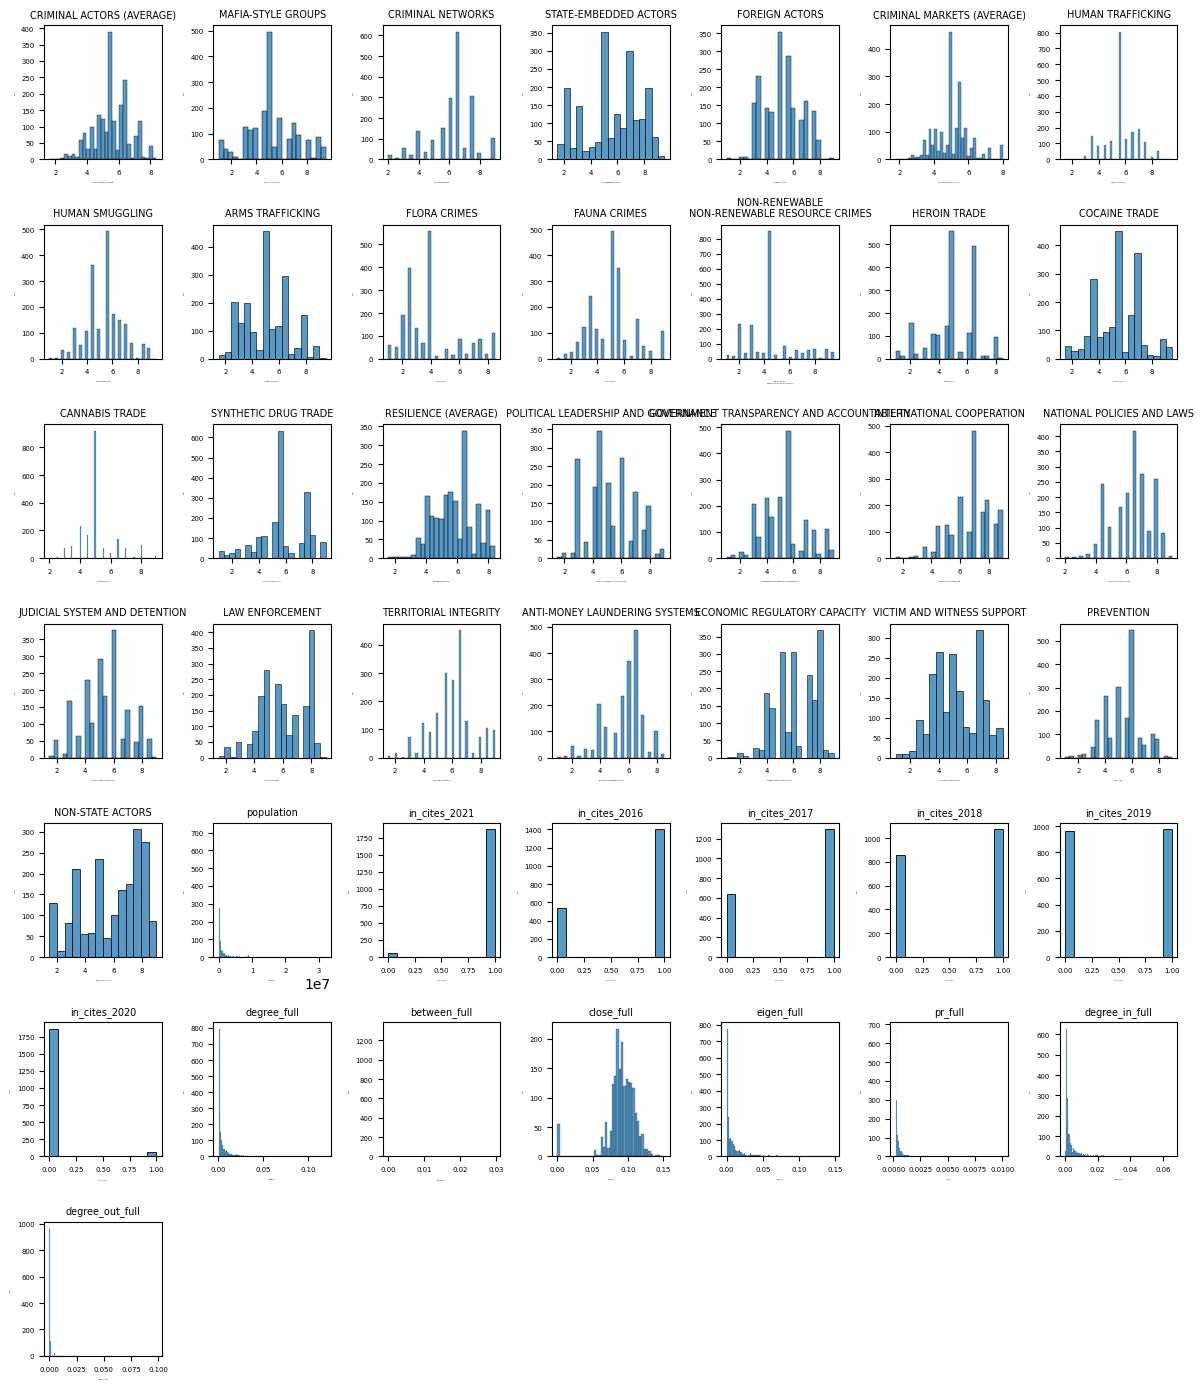

In [362]:
num_cols = 7  # Number of columns in the subplot grid
num_rows = (len(node_feature_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 2*num_rows))

# Plot each feature
for i, column in enumerate(node_feature_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.histplot(node_df[column], ax=ax)
    ax.set_title(column, fontsize=7)  # Set smaller font size for title

    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.tick_params(axis='both', which='minor', labelsize=5)

    ax.set_xlabel(ax.get_xlabel(), fontsize=0) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=0)  

for i in range(len(node_feature_columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### Correlation Analysis

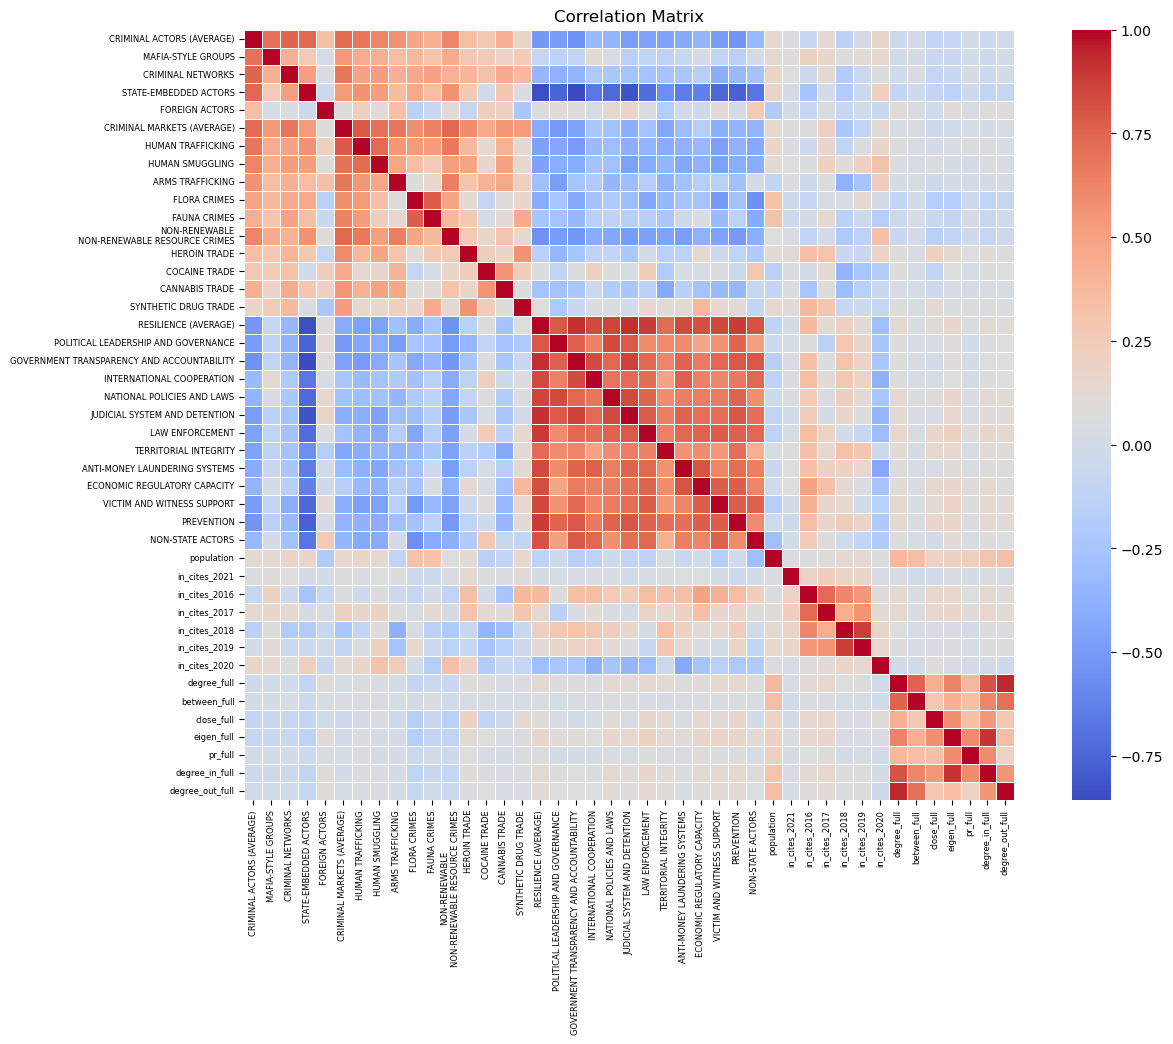

In [ ]:
correlation_matrix_airport = node_df.iloc[:, 14:].corr()

# Set up the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix_airport, annot=False, cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.title('Correlation Matrix', fontsize=12)
plt.show()

In [ ]:
# Compute correlation of each feature with the target variable 'seizure_count'
target_correlation = node_df.iloc[:, 14:].corrwith(node_df['seizure_count'])

# Sort the correlations in descending order
target_correlation = target_correlation.abs().sort_values(ascending=True)

# Plot the correlations
plt.figure(figsize=(16, 16))
sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.title("Correlation of Features with 'seizure_count'")
plt.show()

/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/iwt_path_pred/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


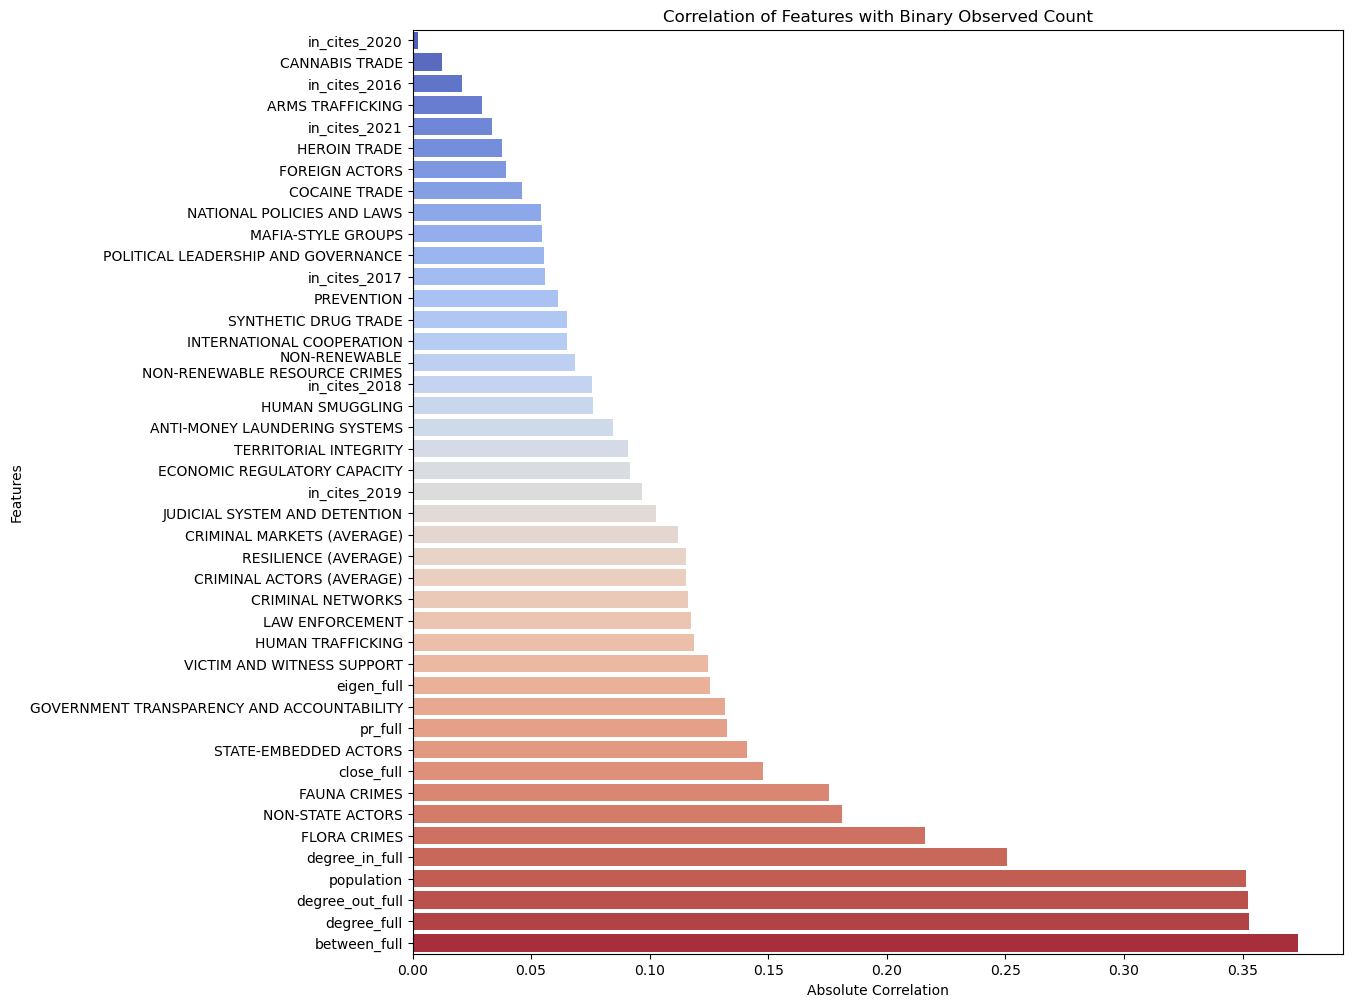

In [ ]:
node_df_new['binary_observed_count'] = (node_df_new['Observed_count'] > 0).astype(int)

# Compute correlation of each feature with the binary target variable 'binary_seizure_count'
target_correlation = node_df_new.iloc[:, 14:-4].corrwith(node_df_new['binary_observed_count'])
target_correlation = target_correlation.abs().sort_values(ascending=True)

plt.figure(figsize=(12, 12))
sns.barplot(x=target_correlation.values, y=target_correlation.index, palette='coolwarm')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.title("Correlation of Features with Binary Observed Count")
plt.show()

In [ ]:
# Replace the variable name below with each variable. Start from those with highest correlation with binary output and move downwards
# return items with a absolute value of correlation greater than 0.8
node_df_new.iloc[:, 15:-4].corrwith(node_df_new['in_cites_2020']).abs() > 0.8

MAFIA-STYLE GROUPS                              False
CRIMINAL NETWORKS                               False
STATE-EMBEDDED ACTORS                           False
FOREIGN ACTORS                                  False
CRIMINAL MARKETS (AVERAGE)                      False
HUMAN TRAFFICKING                               False
HUMAN SMUGGLING                                 False
ARMS TRAFFICKING                                False
FLORA CRIMES                                    False
FAUNA CRIMES                                    False
NON-RENEWABLE\nNON-RENEWABLE RESOURCE CRIMES    False
HEROIN TRADE                                    False
COCAINE TRADE                                   False
CANNABIS TRADE                                  False
SYNTHETIC DRUG TRADE                            False
RESILIENCE (AVERAGE)                            False
POLITICAL LEADERSHIP AND GOVERNANCE             False
GOVERNMENT TRANSPARENCY AND ACCOUNTABILITY      False
INTERNATIONAL COOPERATION   

### Visualize False Predictions from Model

In [ ]:
false_pos_neg = pd.read_excel('false_positives_and_negatives.xlsx')

In [ ]:
def extract_confidence(row):
    probabilities = row['probabilities']
    if row['label'] == 'false_positive':
        confidence = probabilities.rsplit(' ', 5)[1:]
    elif row['label'] == 'false_negative':
        confidence = probabilities.split(' ', 5)[:-1]
    confidence_str = ' '.join(confidence).strip('[]')
    return float(confidence_str)

# Apply the function to each row and create the new 'confidence' column
false_pos_neg['confidence'] = false_pos_neg.apply(extract_confidence, axis=1)

false_pos_neg

Unnamed: 0 IATA    id                                      name  \
0             1  KZN  2990               Kazan International Airport   
1             2  ASF  2966                         Astrakhan Airport   
2            10  KGD  2952                         Khrabrovo Airport   
3            12  LED  2948                           Pulkovo Airport   
4            13  SVX  2975                          Koltsovo Airport   
..          ...  ...   ...                                       ...   
349        1684  POL   985                             Pemba Airport   
350        1710  KAN   270        Mallam Aminu International Airport   
351        1796  RMI  1546    Federico Fellini International Airport   
352        1798  AQJ  2172  Aqaba King Hussein International Airport   
353        1827  MYQ  7774                            Mysore Airport   

               city     country  ICAO   latitude  longitude  altitude  ...  \
0             Kazan      russia  UWKD  55.606201  49.278702       411  ...   
1         Astrakhan      russia  URWA  46.283298  48.006302       -65  ...   
2       Kaliningrad      russia  UMKK  54.889999  20.592600        42  ...   
3    St. Petersburg      russia  ULLI  59.800301  30.262501        78  ...   
4     Yekaterinburg      russia  USSS  56.743099  60.802700       764  ...   
..              ...         ...   ...        ...        ...       ...  ...   
349           Pemba  mozambique  FQPB -12.991762  40.524014       331  ...   
350            Kano     nigeria  DNKN  12.047600   8.524620      1562  ...   
351          Rimini       italy  LIPR  44.020302  12.611700        40  ...   
352           Aqaba      jordan  OJAQ  29.611601  35.018101       175  ...   
353          Mysore       india  VOMY  12.230000  76.655833      2349  ...   

     incident_counts binary_incident_observed binary_origin_observed  \
0                  0                        0                      0   
1                  0                        0                      0   
2                  0                        0                      0   
3                  0                        0                      0   
4                  0                        0                      0   
..               ...                      ...                    ...   
349                1                        1                      1   
350                1                        1                      1   
351                2                        1                      0   
352                1                        1                      0   
353                1                        1                      1   

    binary_destination_observed binary_transit_observed           label  \
0                             0                       0  false_positive   
1                             0                       0  false_positive   
2                             0                       0  false_positive   
3                             0                       0  false_positive   
4                             0                       0  false_positive   
..                          ...                     ...             ...   
349                           0                       0  false_negative   
350                           0                       0  false_negative   
351                           1                       0  false_negative   
352                           1                       0  false_negative   
353                           0                       0  false_negative   

               probabilities  predicted_class  true_class  confidence  
0                [0.45 0.55]                1           0    0.550000  
1                [0.42 0.58]                1           0    0.580000  
2                [0.49 0.51]                1           0    0.510000  
3                [0.18 0.82]                1           0    0.820000  
4                [0.17 0.83]                1           0    0.830000  
..   

/var/folders/px/g1w30xmx4gq5qw1_pnfzn1n40000gn/T/ipykernel_50681/1385516411.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


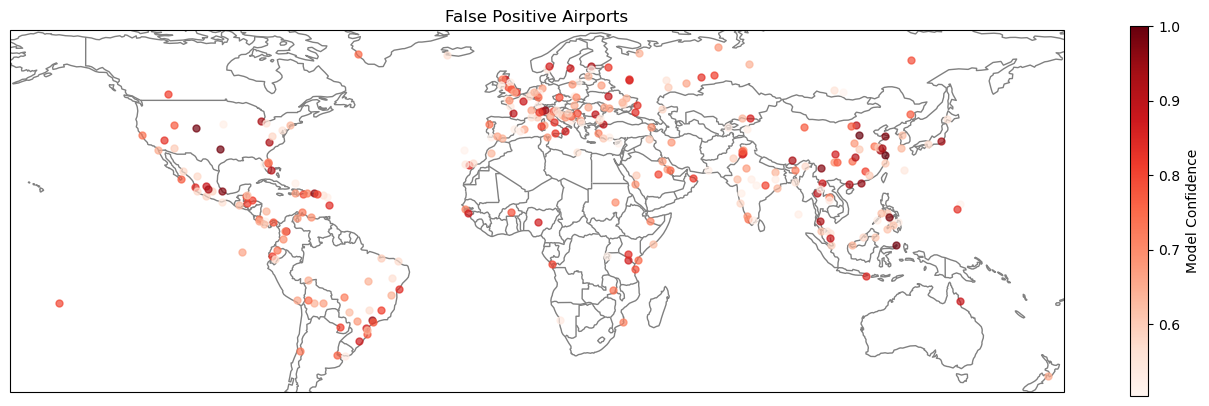

In [ ]:
scaling_factor = 100
fig, ax = plt.subplots(figsize = (17,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(BORDERS, edgecolor='gray')
ax.add_feature(COASTLINE, edgecolor='gray')

# for _, row in false_pos_neg.iterrows():
#     if row['label'] == 'false_positive':
#         iata = row['IATA']
#         lon, lat = row['longitude'], row['latitude']
#         color = 'red' if row['label'] == 'false_positive' else 'blue'
#         marker = 'o' if row['label'] == 'false_positive' else 'v'
#         ax.plot(lon, lat, marker=marker, color=color, markersize=5, alpha=0.5)
#     else:
#         continue


cmap = cm.get_cmap('Reds')
norm = mcolors.Normalize(vmin=false_pos_neg['confidence'].min(), vmax=false_pos_neg['confidence'].max())

for _, row in false_pos_neg.iterrows():
    if row['label'] == 'false_positive':
        iata = row['IATA']
        lon, lat = row['longitude'], row['latitude']
        confidence = row['confidence']
        color = cmap(norm(confidence))
        marker = 'o'
        ax.plot(lon, lat, marker=marker, color=color, markersize=5, alpha=0.7)
    else:
        continue

# Label the top 10 nodes on the map based on their confidence
# top_10 = false_pos_neg.nlargest(10, 'confidence')
# texts = []
# for _, row in top_10.iterrows():
#     lon, lat = row['longitude'], row['latitude']
#     texts.append(ax.text(lon, lat, row['IATA'], fontsize=12, color='black'))
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Add size legend
# sizes = [0.90,0.75,0.50]
# for size in sizes:
#     ax.plot([], [], 'ro', markersize=size*7, alpha = 0.5, label=str(size))
# ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower left', title="Confidence")

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink = 0.4)
cbar.set_label('Model Confidence')

ax.set_title("False Positive Airports")
plt.show()